## Load Drive Folder

In [1]:
from google.colab import drive
drive.mount('/content/drive')
baseurl = '/content/drive/MyDrive/'

### latex
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
###
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'text.usetex':True, 'font.family':'sans-serif', 'font.sans-serif':'Helvetica'}, font='Helvetica')
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

mpl.rc('font',**{'family':'sans-serif','sans-serif':'Helvetica'})
from matplotlib import rc

#rc('text', usetex=True)

Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript javascript-common
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libharfbuzz-icu0 libidn11
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpdfbox-java
  libptexenc1 libruby2.7 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data preview-latex-style
  rake ruby ruby-minitest ruby-net-telnet ruby-power-assert ruby-test-unit
  ruby-xmlrpc ruby2.7 rubygems-integration t1utils tex-common tex-gyre
  texlive-base texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-pictures texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested 

## Extract action selection policy and priors

In [3]:
# Load prior and act sel probs dictionaries
with open(baseurl + 'yt_metadata_category_priors.pkl', 'rb') as f:
    priors = pickle.load(f)
with open(baseurl + 'yt_metadata_category_action_selection_probs.pkl', 'rb') as f:
  actsels = pickle.load(f)

# get an np array of priors (7 x 18) array (7 categories, 18 states)
priorkeys = [elem for elem in list(priors.keys()) if type(elem)==int]
priors_prob = np.array([priors[i] for i in  range(len(priorkeys)) ])
print('Prior array shape: ',priors_prob.shape)


# get an np array of action selection probabilities (8 categories x 18 states x 8 actions) (not 3x2**3 since some actions never arise)
actsels_prob = np.array([actsels[i] for i in  range(len(priorkeys)) ])
print('Action selection array shape: ',actsels_prob.shape)

Prior array shape:  (8, 18)
Action selection array shape:  (8, 18, 8)


## Compute for each category, posterior probability for all other action selection probabilities

In [4]:
posterior_probs_by_category = {}
act_probs_by_category = {}
num_actions = actsels_prob.shape[-1]

for categ in priorkeys: # parametrizes the prior
  act_probs_by_category[categ] = []
  posterior_probs_by_category[categ] = []
  for action in range(num_actions):
    # compute p(a) = prior*p(a|x)
    act_probs_by_category[categ].append(priors_prob[categ,:]@actsels_prob[categ,:,action])
    # compute p(x|a) = p(a|x)*prior/p(a)
    posterior_probs_by_category[categ].append(actsels_prob[categ,:,action]*priors_prob[categ,:]/(actsels_prob[categ,:,action]@priors_prob[categ,:]))

  act_probs_by_category[categ] = np.array(act_probs_by_category[categ])
  posterior_probs_by_category[categ] = np.array(posterior_probs_by_category[categ])

# Save action probs and posterior probs
with open(baseurl + 'yt_metadata_category_act_probs.pkl', 'wb') as f:
  pickle.dump(act_probs_by_category,f)
with open(baseurl + 'yt_metadata_category_posterior_probs.pkl', 'wb') as f:
  pickle.dump(posterior_probs_by_category,f)

# 1. Find Sparsest Utility Function that satisfies NIAS and NIAC

## NIAS, NIAC in functional form (NIAC is no more convex since $\lambda$ x Expected util is bilinear in feasible variables ($\lambda,C,U$)

In [ ]:
def NIAS(feasible_vars, pos_beliefs=posterior_probs_by_category): # check if, given posterior belief, does the agent choose the best action
  '''
  RETURNS a list of NIAS inequality values: [\sum_x p_k(x|a) (u_k(x,b)-u_k(x,a)) for a in range(num_actions) for k in range(num_categs)]
  - Every element of list must be non-positive for NIAS to be feasible


  pos_beliefs.values() -> np arrays
  feasible_vars -> np array
  feasible_vars[0:num_categs*num_states*num_actions] -> utilities u_k(x,a)
  feasible_vars[num_categs*num_states*num_actions + 1 : num_categs*num_states*num_actions + num_categs] -> C_k
  feasible_vars[num_categs*num_states*num_actions + num_categs + 1 : num_categs*num_states*num_actions + num_categs + num_categs] -> \lambda_k

  feasible_vars.shape[0] = num_categs*(num_states*num_actions + 2)
  '''

  belief_shape = pos_beliefs[0].shape
  num_actions = belief_shape[0]
  num_states = belief_shape[1]
  num_categs = len(list(pos_beliefs.keys()))

  assert (feasible_vars.shape)[0] == num_categs*(num_states*num_actions + 2),"Error: Check dimension of feasible_vars"

  utils = feasible_vars[:num_categs*num_states*num_actions]

  ineq_mat = []
  ineq_counter = 0
  for categ in pos_beliefs.keys(): # NIAS for every category
    for a in range(num_actions): # NIAS for every action in every category
      for b in range(num_actions): # NIAS (compare optimal action a to every non-optimal action b for every category)
        if a!=b:
          ## every element must be less than 0 for NIAS to go through   
          ## \sum_{x} p(x|a)*( u(x,b) - u(x,a) ) <= 0
          offset_a = categ*num_states*num_actions + a*num_states
          offset_b = categ*num_states*num_actions + b*num_states

          ineq_mat.append(pos_beliefs[categ][a,:]@np.array(utils[offset_b: offset_b + num_states] - utils[offset_a: offset_a + num_states]))
          ## \sum_x p_k(x|a)*(u_k(x,b) - u_k(x,a)))


          # ineq_mat[ineq_counter, offset_a: offset_a + num_states] = -pos_beliefs[categ][a,:].reshape((1,num_states))
          # ineq_mat[ineq_counter, offset_b: offset_b + num_states] = +pos_beliefs[categ][a,:].reshape((1,num_states))
          #ineq_counter = ineq_counter + 1

          # try:
          #   ineq_mat[ineq_counter, offset_a: offset_a + num_states] = -pos_beliefs[categ][a,:].reshape((1,num_states))
          #   ineq_mat[ineq_counter, offset_b: offset_b + num_states] = +pos_beliefs[categ][a,:].reshape((1,num_states))
          # except:
          #   print(num_categs*num_actions*(num_actions-1),ineq_counter,offset_a,offset_b)         
  return ineq_mat


def NIAC(feasible_vars, pos_beliefs=posterior_probs_by_category,act_prob=act_probs_by_category,act_sels= actsels, priors = priors_prob): # check for relative optimality: for each category, does the chosen action selection policy maximize lambda*expected utility - cost
  '''
  RETURNS a list of NIAC inequality values: [   {exputil(p_{k'}(a|x),u_k(x,a)) - exputil(p_k(a|x),u_k(x,a)) - lambda_k (C_{k'} - C_k) } for k,k' in range(num_categs)**2 and k != k']
  - Every element of list must be non-positive for NIAC to be feasible
  pos_beliefs.values() -> np arrays
  feasible_vars -> np array
  feasible_vars[0:num_categs*num_states*num_actions] -> utilities u_k(x,a)
  feasible_vars[num_categs*num_states*num_actions + 1 : num_categs*num_states*num_actions + num_categs] -> costs C_k
  feasible_vars[num_categs*num_states*num_actions + num_categs + 1 : num_categs*num_states*num_actions + num_categs + num_categs] -> lambda vals \lambda_k

  feasible_vars.shape[0] = num_categs*(num_states*num_actions + 2)

  RETURNS a list of NIAC inequality values: [   {exputil(p_{k'}(a|x),u_k(x,a)) - exputil(p_k(a|x),u_k(x,a)) - lambda_k (C_{k'} - C_k) } for k,k' in range(num_categs)**2 and k != k']
  - Every element of list must be non-positive for NIAC to be feasible

  '''

  belief_shape = pos_beliefs[0].shape
  num_actions = belief_shape[0]
  num_states = belief_shape[1]
  num_categs = len(list(pos_beliefs.keys()))

  assert (feasible_vars.shape)[0] == num_categs*(num_states*num_actions + 2),"Error: Check dimension of feasible_vars"

  utils = feasible_vars[:num_categs*num_states*num_actions]
  costs = feasible_vars[num_categs*num_states*num_actions: num_categs*num_states*num_actions + num_categs]
  lambdas = feasible_vars[num_categs*num_states*num_actions + num_categs:]

  ineq_mat = []
  for categ1 in pos_beliefs.keys(): # NIAC is for a pair of categories - categ1 has higher expected utility
    for categ2 in pos_beliefs.keys():
      if categ1 != categ2:
        offset = categ1*num_states*num_actions
        exputil1 = sum([ act_prob[categ1][a]*(pos_beliefs[categ1][a,:]@utils[ offset + a*num_states: offset + (a+1)*num_states]) for a in range(num_actions) ])
        # \sum_{x,a} p_k(x|a)p_k(a)u_k(x,a)

        cross_pos_beliefs = np.zeros(pos_beliefs[0].shape)
        cross_act_probs = np.zeros((num_actions,))
        act_sel_2 = np.array(act_sels[categ2])

        for a in range(num_actions):
          cross_pos_beliefs[a,:] = priors[categ1]*np.array(act_sel_2[:,a]).reshape((num_states,))  #### (prior(x)p_{k'}(a|x))
          cross_act_probs[a] = sum(cross_pos_beliefs[a,:]) #### sum_{x} (prior(x')p_{k'}(a|x'))
          cross_pos_beliefs[a,:] = cross_pos_beliefs[a,:]/cross_act_probs[a] #### (prior(x)p_{k'}(a|x))/sum_{x} (prior(x')p_{k'}(a|x'))
 
        offset = categ1*num_actions*num_states
        exputil2 = sum([ cross_act_probs[a]*max( [cross_pos_beliefs[a,:]@utils[offset + a1*num_states: offset + (a1+1)*num_states] for a1 in range(num_actions)]  ) for a in range(num_actions)])
        # \sum_{a} p_{k'}(a) (\max_{b} \sum_{x} p_{k'}(x|a) u_{k}(x,a)) - cross max utility gained by using action selection from k' in category k

        ## Debugging blurb: print(categ1,categ2,'utils',exputil1,exputil2)
        ineq_mat.append(  exputil2 - exputil1 - lambdas[categ1]*(costs[categ2] - costs[categ1])  )

  return ineq_mat



## Example of NIAS and NIAC in action


In [ ]:
vars = np.random.rand(8*(8*18+2),)  # number of feasible elements = num_categs*(num_states*num_actions + 2) -> see help(NIAS), help(NIAC) for info
NIAS_arr = NIAS(vars)
NIAC_arr = NIAC(vars)


print('Fraction that satisfies NIAS: {}'.format(sum([1 for elem in NIAS_arr if elem>=0])/len(NIAS_arr)))
print('Fraction that satisfies NIAC: {}'.format(sum([1 for elem in NIAC_arr if elem>=0])/len(NIAC_arr)))

Fraction that satisfies NIAS: 0.5357142857142857
Fraction that satisfies NIAC: 0.6785714285714286


In [ ]:
def sparsest_utility(feasible_vars,pos_beliefs = posterior_probs_by_category):
  '''
  RETURNS \sum_{x,a,k} |u_k(x,a)| -> sum of absolute values of the utilities (just the sum since utilities are constrained to be >= 0)
  
  pos_beliefs.values() -> np arrays
  feasible_vars -> np array
  feasible_vars[0:num_categs*num_states*num_actions] -> utilities u_k(x,a)
  feasible_vars[num_categs*num_states*num_actions + 1 : num_categs*num_states*num_actions + num_categs] -> costs C_k
  feasible_vars[num_categs*num_states*num_actions + num_categs + 1 : num_categs*num_states*num_actions + num_categs + num_categs] -> lambda vals \lambda_k

  feasible_vars.shape[0] = num_categs*(num_states*num_actions + 2)

  '''

  belief_shape = pos_beliefs[0].shape
  num_actions = belief_shape[0]
  num_states = belief_shape[1]
  num_categs = len(list(pos_beliefs.keys()))

  assert (feasible_vars.shape)[0] == num_categs*(num_states*num_actions + 2),"Error: Check dimension of feasible_vars"
  return float(sum(np.absolute(feasible_vars[:num_categs*num_states*num_actions])))

def grad_sparsest_utility(feasible_vars,pos_beliefs = posterior_probs_by_category):
  '''
  RETURNS \sum_{x,a,k} |u_k(x,a)| -> sum of absolute values of the utilities (just the sum since utilities are constrained to be >= 0)
  
  pos_beliefs.values() -> np arrays
  feasible_vars -> np array
  feasible_vars[0:num_categs*num_states*num_actions] -> utilities u_k(x,a)
  feasible_vars[num_categs*num_states*num_actions + 1 : num_categs*num_states*num_actions + num_categs] -> costs C_k
  feasible_vars[num_categs*num_states*num_actions + num_categs + 1 : num_categs*num_states*num_actions + num_categs + num_categs] -> lambda vals \lambda_k

  feasible_vars.shape[0] = num_categs*(num_states*num_actions + 2)

  '''

  belief_shape = pos_beliefs[0].shape
  num_actions = belief_shape[0]
  num_states = belief_shape[1]
  num_categs = len(list(pos_beliefs.keys()))

  assert (feasible_vars.shape)[0] == num_categs*(num_states*num_actions + 2),"Error: Check dimension of feasible_vars"
  return np.ones((num_categs*(num_states*num_actions + 2),))


### Find sparsest utility that satisfies NIAS and NIAC ###
from scipy.optimize import minimize, NonlinearConstraint, Bounds

thresh_nias = -0.0001
thresh_niac = -0.001
thresh_vars = 0.001
belief_shape = posterior_probs_by_category[0].shape

num_actions = belief_shape[0]
num_states = belief_shape[1]
num_categs = len(list(posterior_probs_by_category.keys()))


bounds = Bounds([(0,1)]*(num_categs*(num_states*num_actions + 2)))

# minimize sum of absolute utilities subject to NIAS <= thresh_nias, NIAC <= thresh_niac


#### TAKES A LOT OF TIME ####
res_sparsest = minimize(fun = sparsest_utility,
                        x0= 0.5*np.ones((num_categs*(num_actions*num_states + 2),)),
                        bounds =  [(thresh_vars,1)]*(num_categs*(num_states*num_actions + 2)), # every element is between [0,1]
                        jac = grad_sparsest_utility,
                        constraints = (NonlinearConstraint(NIAS, -np.inf, thresh_nias),NonlinearConstraint(NIAC, -np.inf, thresh_niac),),
                        options={'disp': True}
                        )



/usr/local/lib/python3.9/dist-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


More than 3*n iterations in LSQ subproblem    (Exit mode 3)
            Current function value: 2.923814796034373
            Iterations: 39
            Function evaluations: 149
            Gradient evaluations: 39


In [ ]:
vals = res_sparsest.x
sparse_utils = vals[:num_categs*num_states*num_actions]
costs = vals[num_categs*num_states*num_actions:num_categs*num_states*num_actions + num_categs]
lambdas = vals[num_categs*num_states*num_actions + num_categs:]

##### shape utilities into a dictionary:
sparse_utils_dict = {}
for categ in range(num_categs):
  sparse_utils_dict[categ] = sparse_utils[categ*num_states*num_actions: (categ+1)*num_states*num_actions].reshape((num_actions,num_states))

sparse_utils_dict['Summary']='Storing sparsest utilities of 8 categories - rows are actions, columns are states'


sparse_final_utils_costs_lambdas_data = {
    'utils':sparse_utils_dict,
    'inattention_costs':costs,
    'lagrange_cost_multipliers':lambdas
}


# Save Sparse utils and costs and lambdas
with open(baseurl + 'yt_metadata_final_sparse.pkl', 'wb') as f:
  pickle.dump(sparse_final_utils_costs_lambdas_data,f)


## Sparse Utility Visualization

<ipython-input-5-46574b638003>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_for_plots = cm.get_cmap('viridis', num_categs)


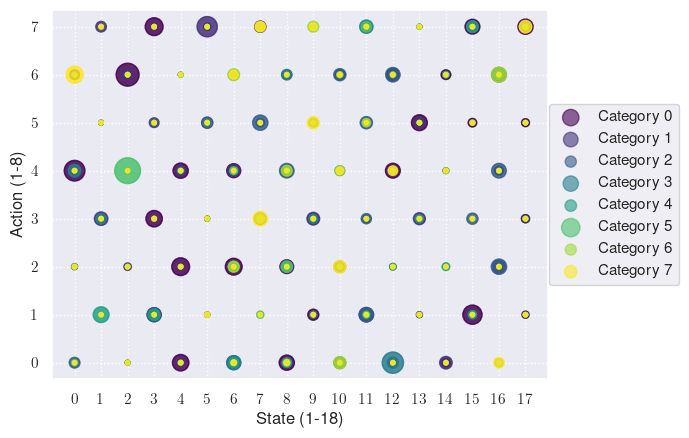

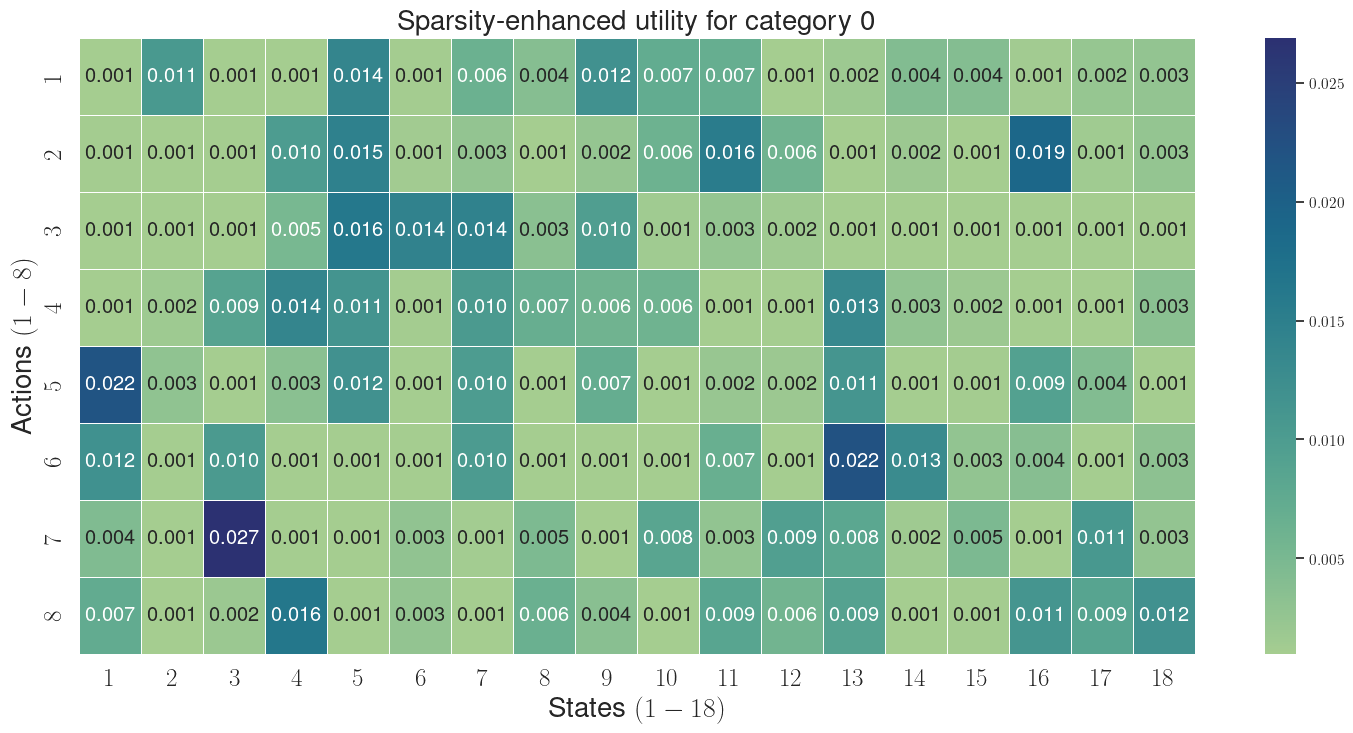

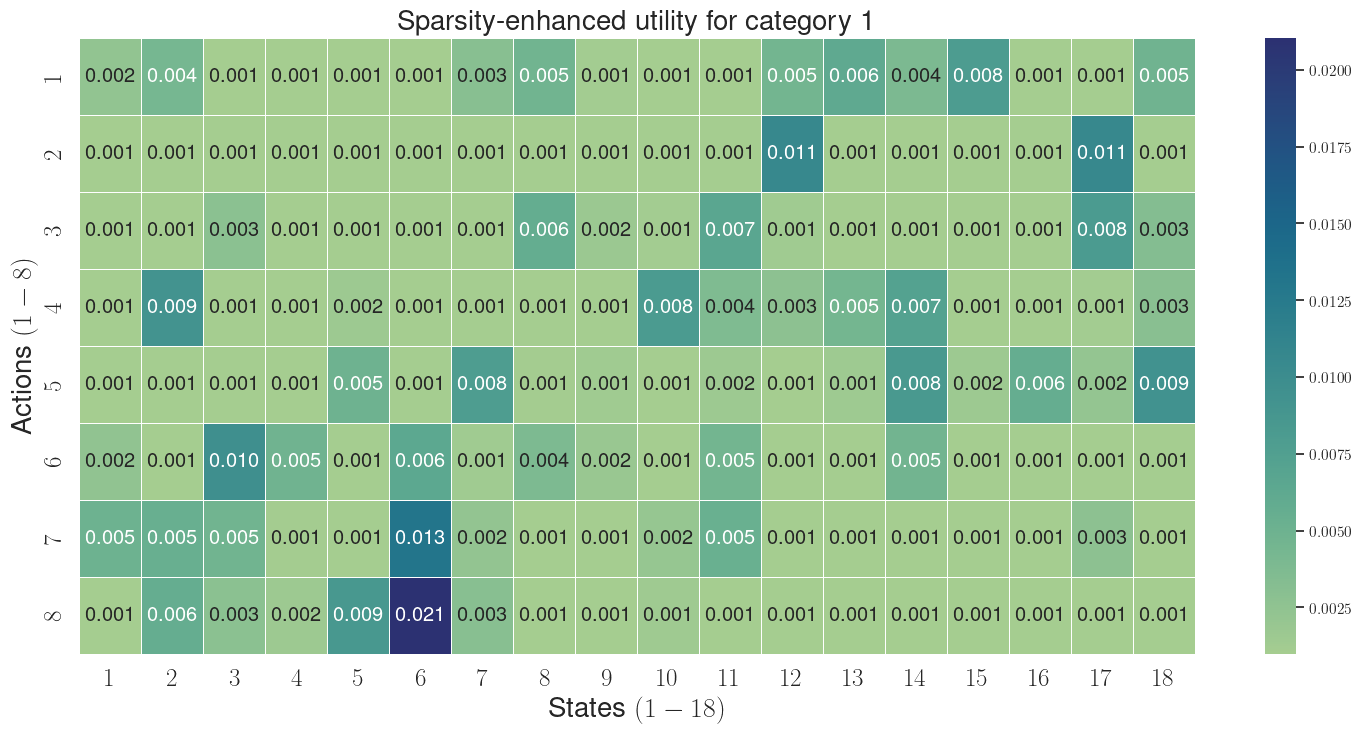

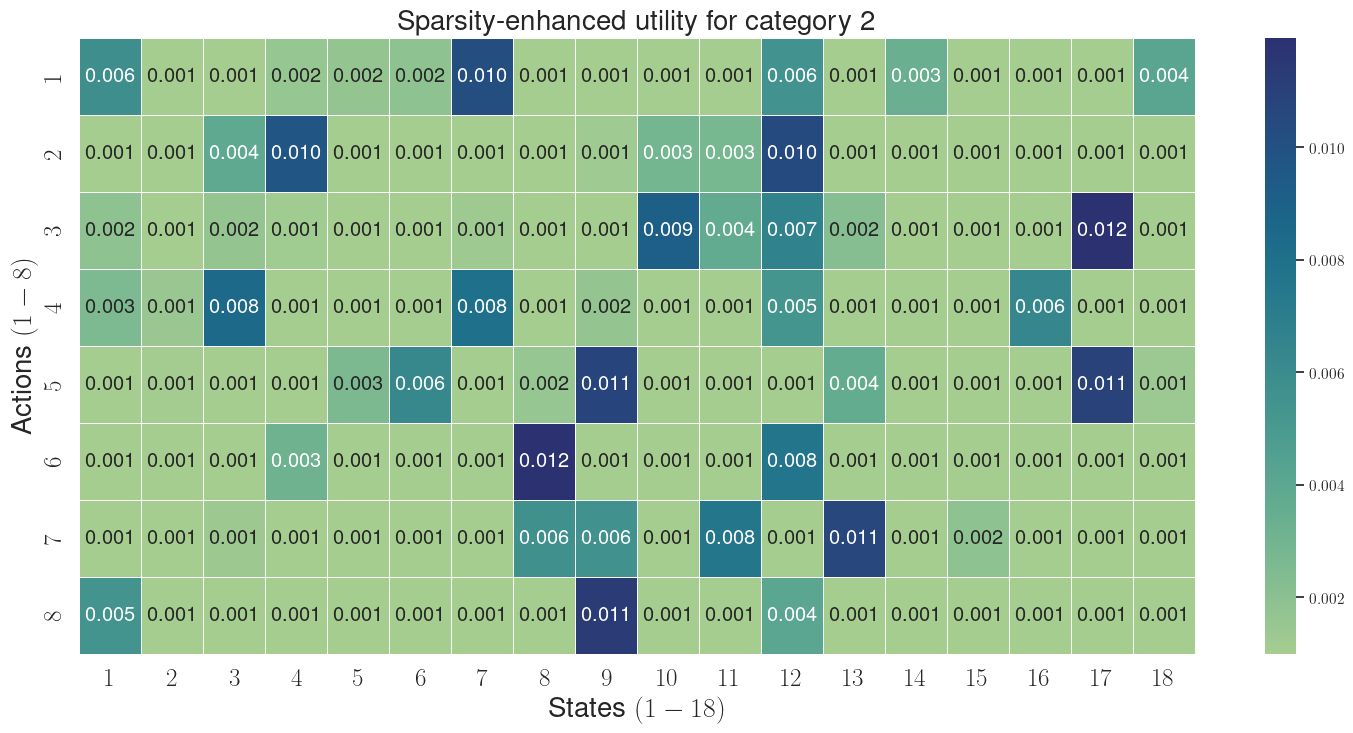

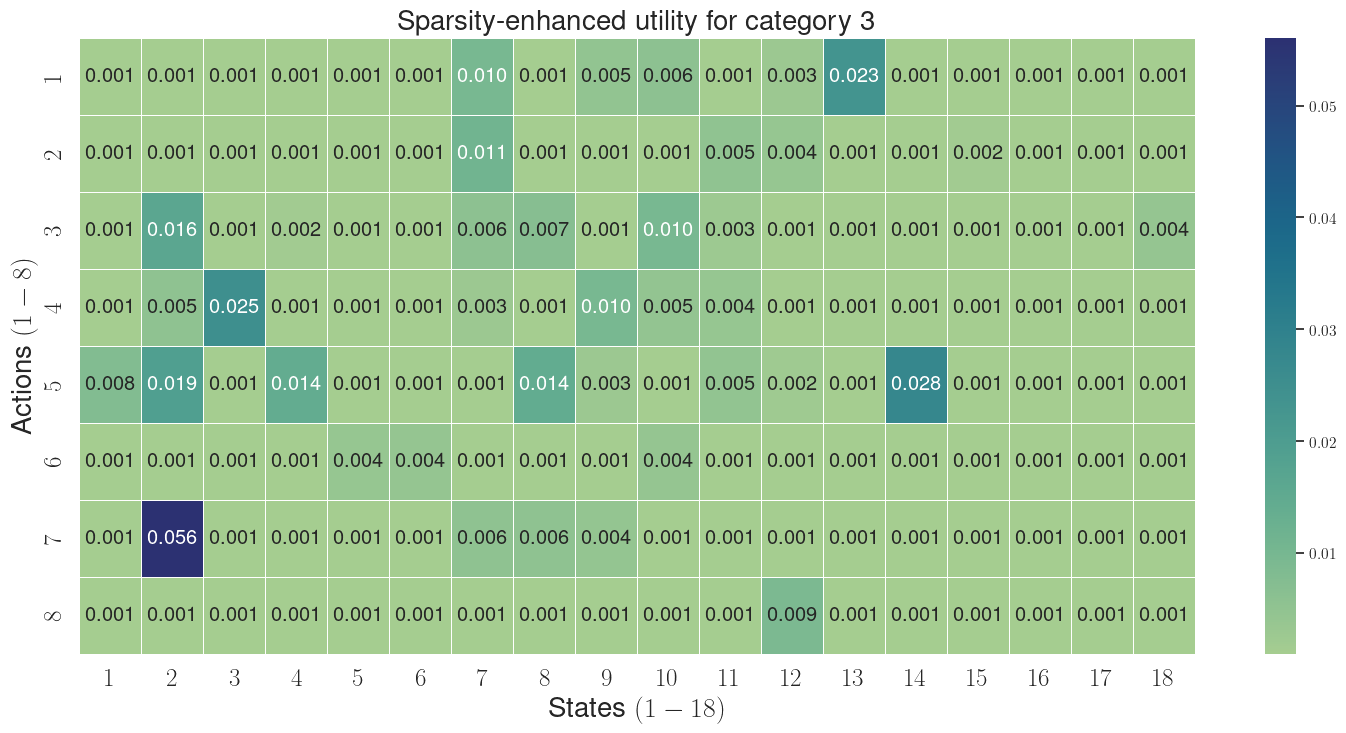

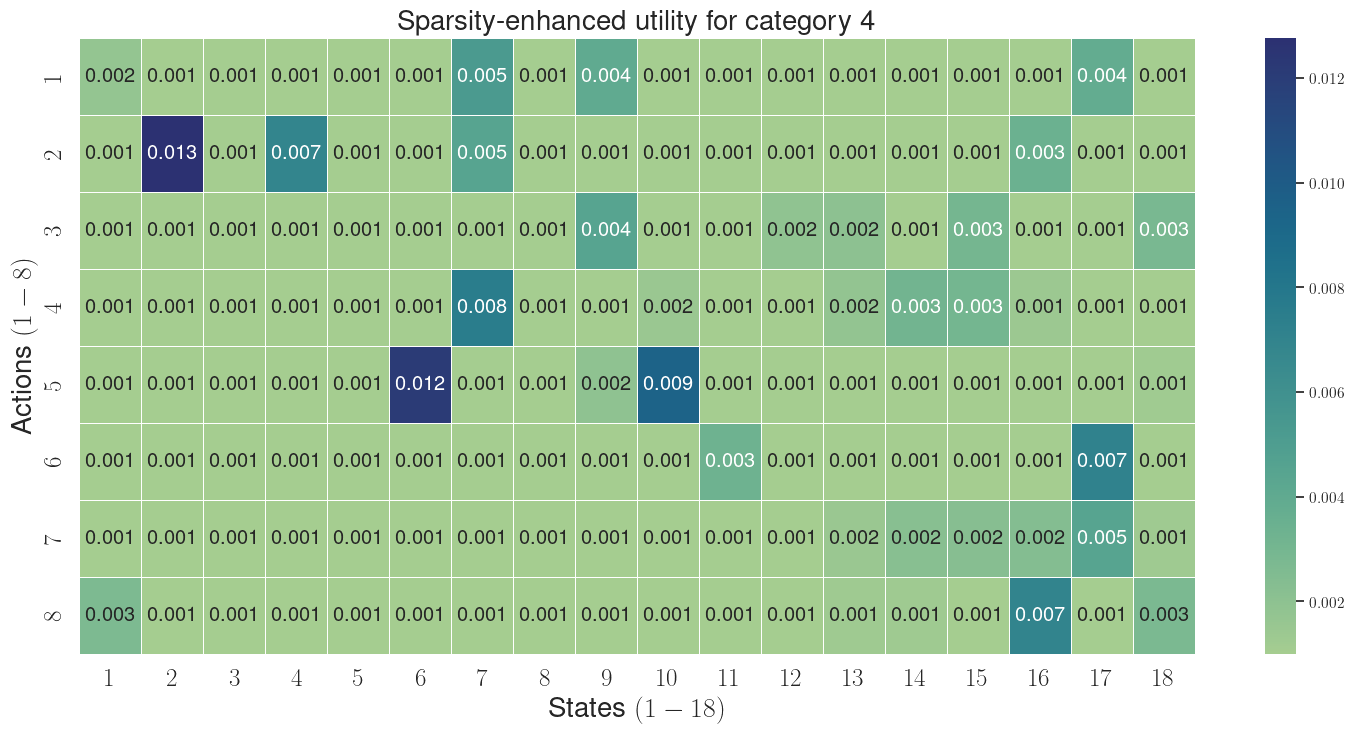

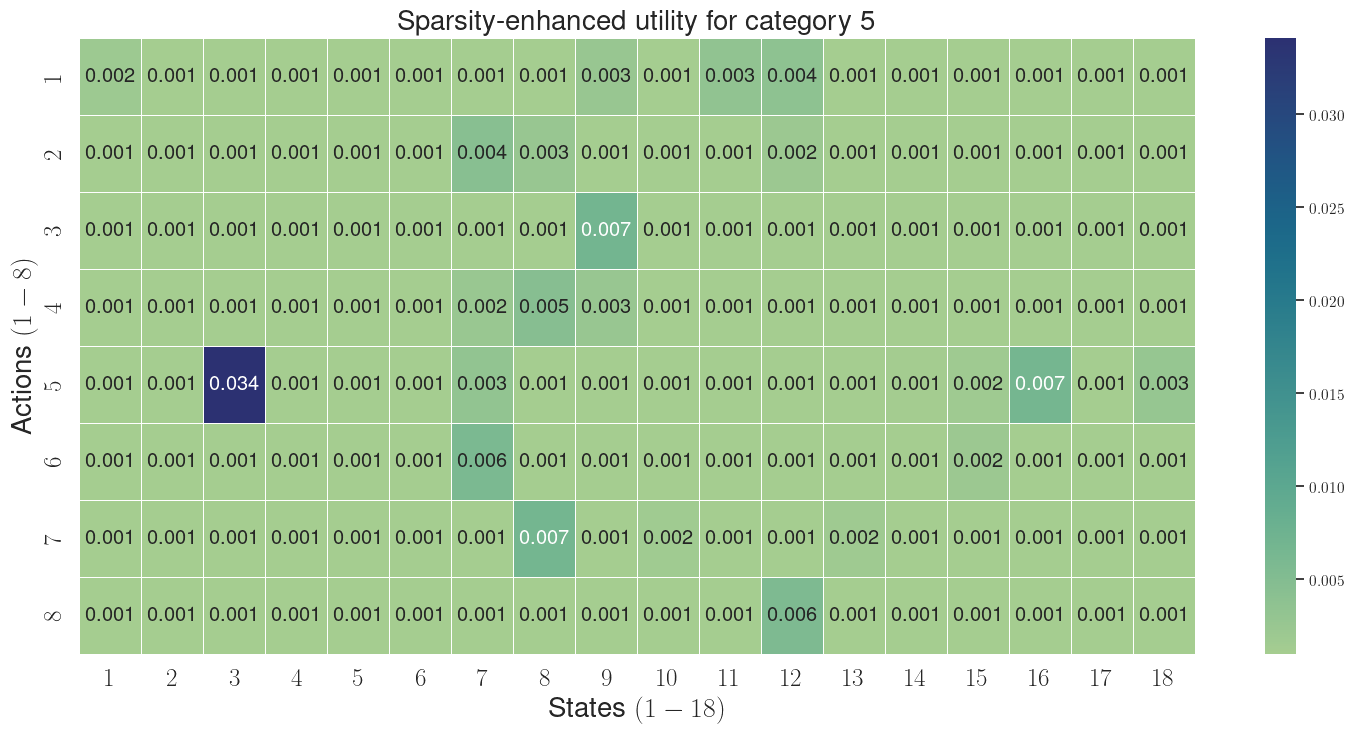

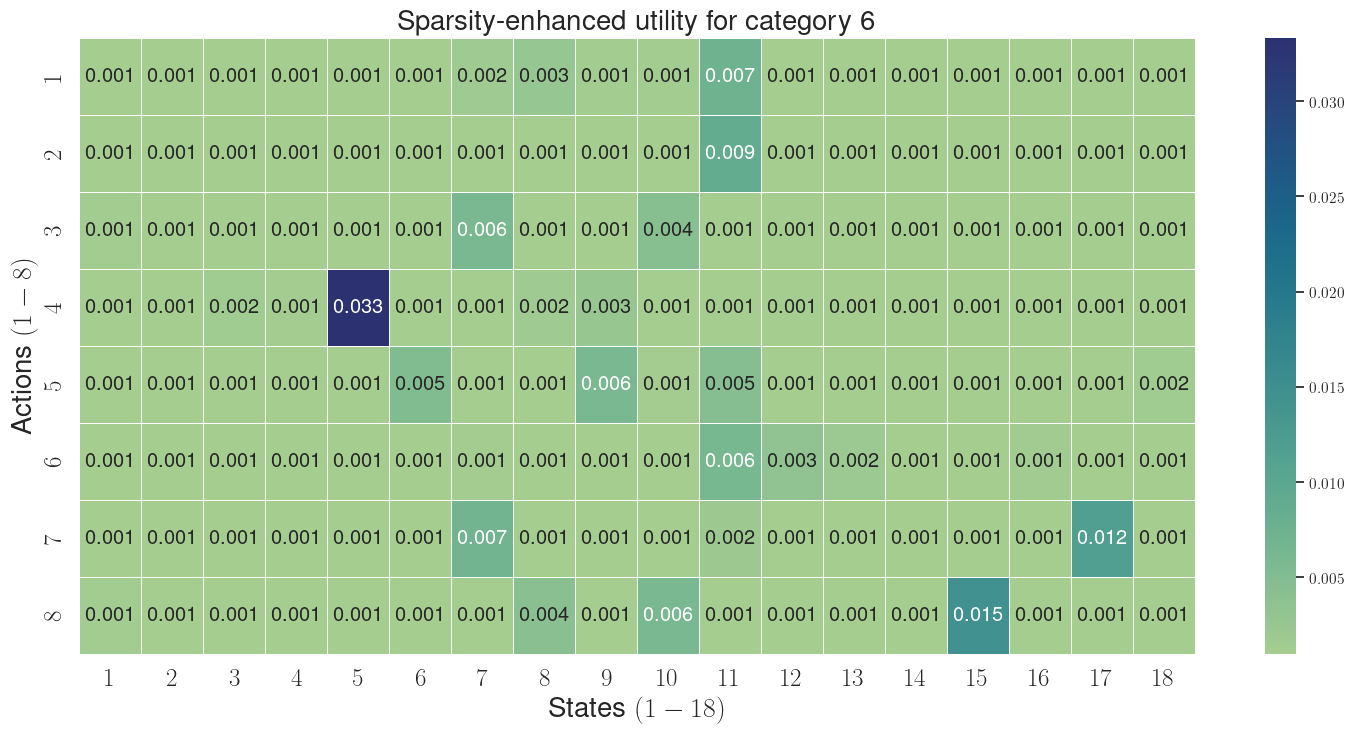

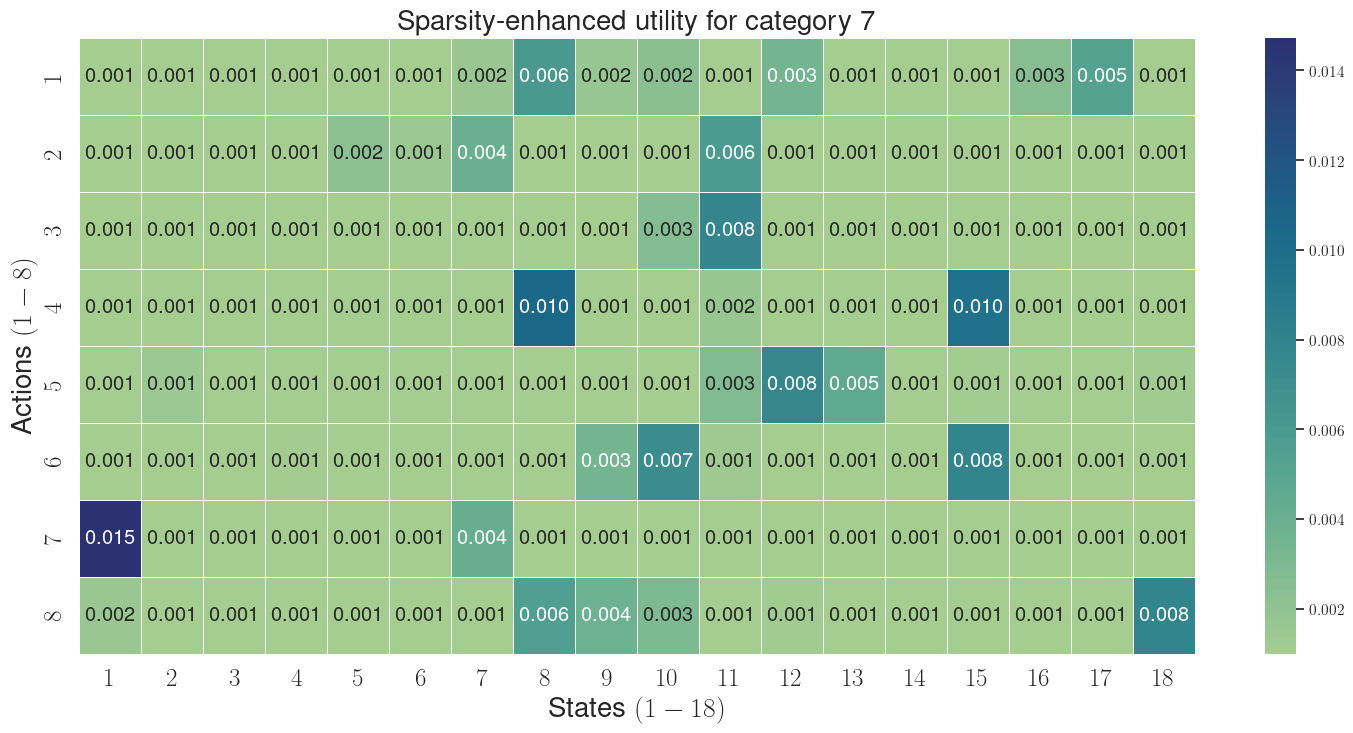

In [5]:
try:
  with open(baseurl + 'yt_metadata_final_sparse.pkl', 'rb') as f:
    sparse_data = pickle.load(f)
except:
  print("Sorry, the file you are looking for does not exist")

utils = sparse_data['utils']
import matplotlib.pyplot as plt
from matplotlib import cm

## create grid
belief_shape = posterior_probs_by_category[0].shape
num_states = belief_shape[1]
num_actions = belief_shape[0]
num_categs = len(list(posterior_probs_by_category.keys()))

state_grid = list(range(num_states))*num_actions
action_grid = list(range(num_actions))*num_states

sparseutils_viz = {}
sparseutils_viz['state_grid'] = state_grid
sparseutils_viz['action_grid'] = action_grid

cmap_for_plots = cm.get_cmap('viridis', num_categs)

# fig, axs = plt.subplots(2, 4)


# for categ in range(num_categs):
#   sparseutils_viz[categ] = [sparse_data['utils'][categ][action_grid[i],state_grid[i]] for i in range(num_states*num_actions)]
#   axs[int(2*categ//num_categs), categ%(int(num_categs/2)) ].scatter(state_grid,action_grid,
#               c = [cmap_for_plots.colors[categ]]*(num_states*num_actions),
#               s=900*np.array(sparseutils_viz[categ]),
#               alpha = 0.6)
#   # plt.grid('on')
#   # axs[int(2*categ//num_categs), categ%(int(num_categs/2)) ].xlabel('State (0-17)')
#   # axs[int(2*categ//num_categs), categ%(int(num_categs/2)) ].ylabel('Action (0-7)')
#   # axs[int(2*categ//num_categs), categ%(int(num_categs/2)) ].xticks(list(range(num_states)))
#   # axs[int(2*categ//num_categs), categ%(int(num_categs/2)) ].yticks(list(range(num_actions)))
#   #plt.legend(list(posterior_probs_by_category.keys()) )

plt.figure()
for categ in range(num_categs):
  sparseutils_viz[categ] = [sparse_data['utils'][categ][action_grid[i],state_grid[i]] for i in range(num_states*num_actions)]
  plt.scatter(state_grid,action_grid,
              c = [cmap_for_plots.colors[categ]]*(num_states*num_actions),
              s= 10000*np.array(sparseutils_viz[categ]),
              alpha = 0.6)
plt.grid(linestyle='dotted')
plt.xlabel(r'State (1-18)')
plt.ylabel(r'Action (1-8)')
plt.xticks(list(range(num_states)))
plt.yticks(list(range(num_actions)))
plt.legend(['Category ' + str(key) for key in list(posterior_probs_by_category.keys())], loc = 'right', bbox_to_anchor=(1.28, 0.5) )


##################################

import seaborn as sns
for categ in range(num_categs):
  plt.figure(figsize = (num_states,num_actions))
  ax = sns.heatmap(sparse_data['utils'][categ],cmap = 'crest', annot = True, annot_kws = {'fontsize':14.5}, cbar_kws = {'shrink':1}, fmt = '.3f',  linewidth = .5)
  #ax.set(xlabel = 'States (0-17)', ylabel = 'Actions (0-7)', title = 'Sparsity-enhanced utility for category {}'.format(categ))
  ax.set_xlabel(r'States $(1-18)$', fontsize=20)
  ax.set_ylabel(r'Actions $(1-8)$', fontsize=20)
  ax.set_title(r'Sparsity-enhanced utility for category {}'.format(categ), fontsize = 20)
  ax.set_xticklabels([r"$%d$" % (y+1) for y in range(num_states)], fontsize=18)
  ax.set_yticklabels([r"$%d$" % (y+1) for y in range(num_actions)], fontsize=18)
  
  plt.show()




## Contour Plots

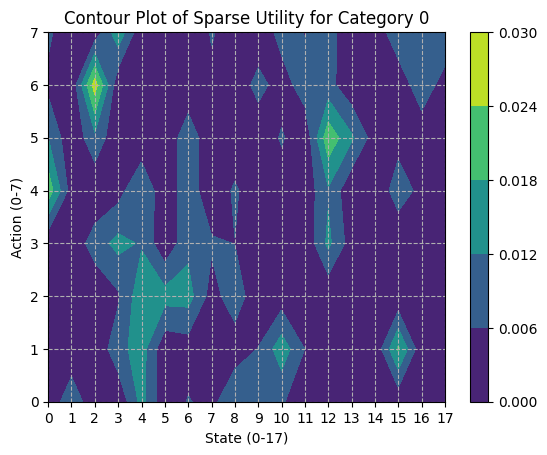

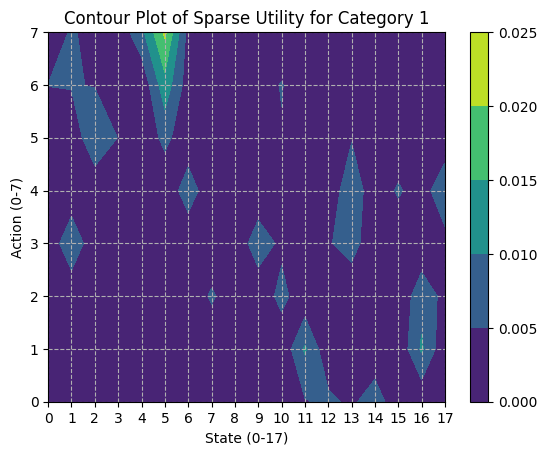

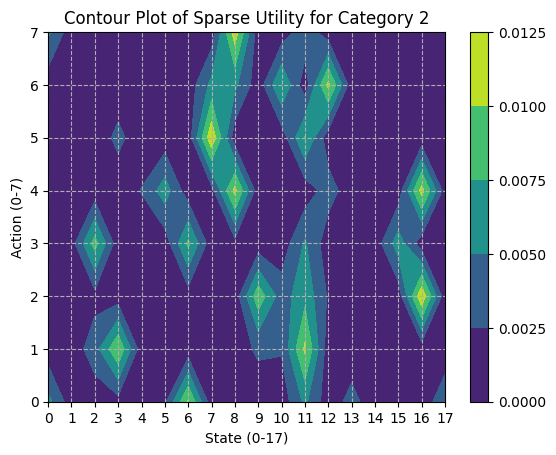

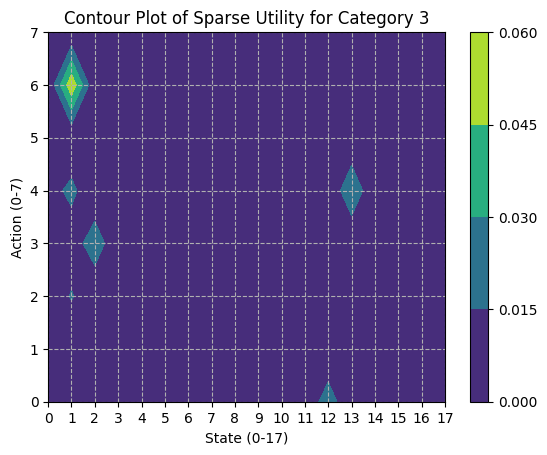

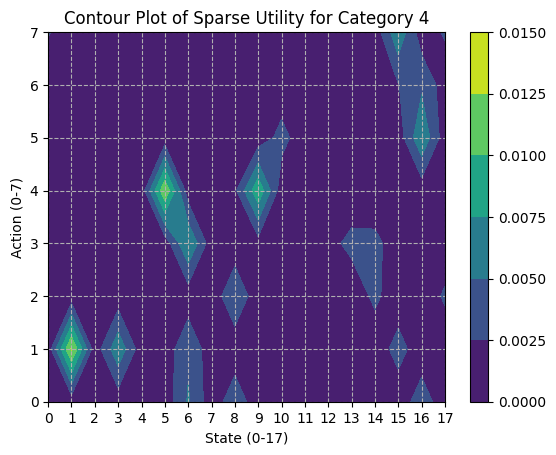

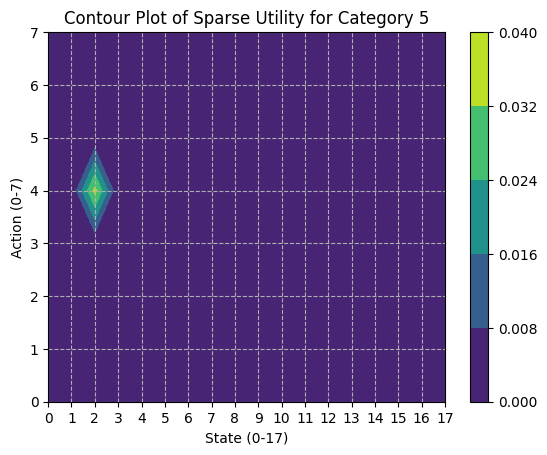

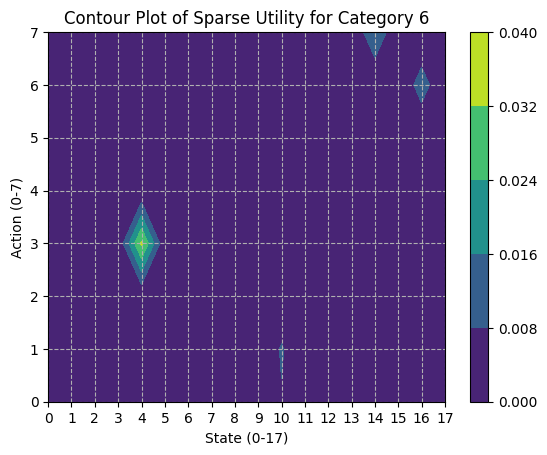

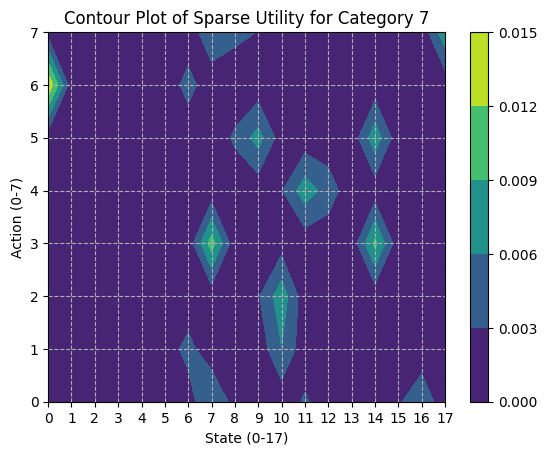

In [ ]:
[X, Y] = np.meshgrid(np.arange(num_states), np.arange(num_actions))

for categ in range(num_categs):
  Z = np.zeros(X.shape)
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      Z[i,j] = sparse_data['utils'][categ][i,j]
  fig,ax =  plt.subplots()
  cs = ax.contourf(X,Y,Z, levels = 4, alpha = 1)
  plt.xlabel('State (1-18)')
  plt.ylabel('Action (1-8)')
  plt.grid(linestyle='dashed')
  plt.xticks(list(range(num_states)))
  plt.yticks(list(range(num_actions)))
  plt.title('Contour Plot of Sparse Utility for Category {}'.format(categ))
  cbar = fig.colorbar(cs)
  plt.show()
  


# 2. Find Max. Margin Utility Function that satisfies NIAS and NIAC

In [ ]:
def NIAS_margin(feasible_vars, pos_beliefs=posterior_probs_by_category): # check if, given posterior belief, does the agent choose the best action
  '''
  RETURNS a list of NIAS inequality values: [\sum_x p_k(x|a) (u_k(x,b)-u_k(x,a)) + margin_nias for a in range(num_actions) for k in range(num_categs)]
  - Every element of list must be non-positive for NIAS to be feasible

  pos_beliefs.values() -> np arrays
  feasible_vars -> np array
  feasible_vars[0:num_categs*num_states*num_actions] -> utilities u_k(x,a)
  feasible_vars[num_categs*num_states*num_actions + 1 : num_categs*num_states*num_actions + num_categs] -> C_k
  feasible_vars[num_categs*num_states*num_actions + num_categs + 1 : num_categs*num_states*num_actions + num_categs + num_categs] -> \lambda_k

  feasible_vars[-1] -> niac margin, feasible_vars[-2] -> nias margin

  feasible_vars.shape[0] = num_categs*(num_states*num_actions + 2) + 2
  '''

  belief_shape = pos_beliefs[0].shape
  num_actions = belief_shape[0]
  num_states = belief_shape[1]
  num_categs = len(list(pos_beliefs.keys()))

  assert (feasible_vars.shape)[0] == num_categs*(num_states*num_actions + 2) + 2,"Error: Check dimension of feasible_vars"

  utils = feasible_vars[:num_categs*num_states*num_actions]

  ineq_mat = []
  ineq_counter = 0
  for categ in pos_beliefs.keys(): # NIAS for every category
    for a in range(num_actions): # NIAS for every action in every category
      for b in range(num_actions): # NIAS (compare optimal action a to every non-optimal action b for every category)
        if a!=b:
          ## every element must be less than 0 for NIAS to go through   
          ## \sum_{x} p(x|a)*( u(x,b) - u(x,a) ) <= 0
          offset_a = categ*num_states*num_actions + a*num_states
          offset_b = categ*num_states*num_actions + b*num_states

          ineq_mat.append(pos_beliefs[categ][a,:]@np.array(utils[offset_b: offset_b + num_states] - utils[offset_a: offset_a + num_states]) + feasible_vars[-2] ) # include margin in nias
          ## \sum_x p_k(x|a)*(u_k(x,b) - u_k(x,a)))


          # ineq_mat[ineq_counter, offset_a: offset_a + num_states] = -pos_beliefs[categ][a,:].reshape((1,num_states))
          # ineq_mat[ineq_counter, offset_b: offset_b + num_states] = +pos_beliefs[categ][a,:].reshape((1,num_states))
          #ineq_counter = ineq_counter + 1

          # try:
          #   ineq_mat[ineq_counter, offset_a: offset_a + num_states] = -pos_beliefs[categ][a,:].reshape((1,num_states))
          #   ineq_mat[ineq_counter, offset_b: offset_b + num_states] = +pos_beliefs[categ][a,:].reshape((1,num_states))
          # except:
          #   print(num_categs*num_actions*(num_actions-1),ineq_counter,offset_a,offset_b)         
  return ineq_mat




def NIAC_margin(feasible_vars, pos_beliefs=posterior_probs_by_category,act_prob=act_probs_by_category,act_sels= actsels, priors = priors_prob): # check for relative optimality: for each category, does the chosen action selection policy maximize lambda*expected utility - cost
  '''
  RETURNS a list of NIAC inequality values: [   {exputil(p_{k'}(a|x),u_k(x,a)) - exputil(p_k(a|x),u_k(x,a)) - lambda_k (C_{k'} - C_k) } + margin_niac for k,k' in range(num_categs)**2 and k != k']
  - Every element of list must be non-positive for NIAC to be feasible

  pos_beliefs.values() -> np arrays
  feasible_vars -> np array
  feasible_vars[0:num_categs*num_states*num_actions] -> utilities u_k(x,a)
  feasible_vars[num_categs*num_states*num_actions + 1 : num_categs*num_states*num_actions + num_categs] -> costs C_k
  feasible_vars[num_categs*num_states*num_actions + num_categs + 1 : num_categs*num_states*num_actions + num_categs + num_categs] -> lambda vals \lambda_k
  
  
  feasible_vars[-1] -> niac margin, feasible_vars[-2] -> nias margin

  feasible_vars.shape[0] = num_categs*(num_states*num_actions + 2) + 2
  '''

  belief_shape = pos_beliefs[0].shape
  num_actions = belief_shape[0]
  num_states = belief_shape[1]
  num_categs = len(list(pos_beliefs.keys()))

  assert (feasible_vars.shape)[0] == num_categs*(num_states*num_actions + 2) + 2,"Error: Check dimension of feasible_vars"

  utils = feasible_vars[:num_categs*num_states*num_actions]
  costs = feasible_vars[num_categs*num_states*num_actions: num_categs*num_states*num_actions + num_categs]
  lambdas = feasible_vars[num_categs*num_states*num_actions + num_categs:]

  ineq_mat = []
  for categ1 in pos_beliefs.keys(): # NIAC is for a pair of categories - categ1 has higher expected utility
    for categ2 in pos_beliefs.keys():
      if categ1 != categ2:
        offset = categ1*num_states*num_actions
        exputil1 = sum([ act_prob[categ1][a]*(pos_beliefs[categ1][a,:]@utils[ offset + a*num_states: offset + (a+1)*num_states]) for a in range(num_actions) ])
        # \sum_{x,a} p_k(x|a)p_k(a)u_k(x,a)

        cross_pos_beliefs = np.zeros(pos_beliefs[0].shape)
        cross_act_probs = np.zeros((num_actions,))
        act_sel_2 = np.array(act_sels[categ2])

        for a in range(num_actions):
          cross_pos_beliefs[a,:] = priors[categ1]*np.array(act_sel_2[:,a]).reshape((num_states,))  #### (prior(x)p_{k'}(a|x))
          cross_act_probs[a] = sum(cross_pos_beliefs[a,:]) #### sum_{x} (prior(x')p_{k'}(a|x'))
          cross_pos_beliefs[a,:] = cross_pos_beliefs[a,:]/cross_act_probs[a] #### (prior(x)p_{k'}(a|x))/sum_{x} (prior(x')p_{k'}(a|x'))
 
        offset = categ1*num_actions*num_states
        exputil2 = sum([ cross_act_probs[a]*max( [cross_pos_beliefs[a,:]@utils[offset + a1*num_states: offset + (a1+1)*num_states] for a1 in range(num_actions)]  ) for a in range(num_actions)])
        # \sum_{a} p_{k'}(a) (\max_{b} \sum_{x} p_{k'}(x|a) u_{k}(x,a)) - cross max utility gained by using action selection from k' in category k

        ## Debuggin blurb: print(categ1,categ2,'utils',exputil1,exputil2)
        ineq_mat.append(  exputil2 - exputil1 - lambdas[categ1]*(costs[categ2] - costs[categ1]) + feasible_vars[-1] ) # include margin in niac

  return ineq_mat



In [ ]:
def max_margin_utility(feasible_vars,pos_beliefs = posterior_probs_by_category):
  '''
  RETURNS NEGATIVE OF sum of margins for nias and niac (since we are minimizing)

  pos_beliefs.values() -> np arrays
  feasible_vars -> np array
  feasible_vars[0:num_categs*num_states*num_actions] -> utilities u_k(x,a)
  feasible_vars[num_categs*num_states*num_actions + 1 : num_categs*num_states*num_actions + num_categs] -> costs C_k
  feasible_vars[num_categs*num_states*num_actions + num_categs + 1 : num_categs*num_states*num_actions + num_categs + num_categs] -> lambda vals \lambda_k

  feasible_vars[-1] -> niac margin, feasible_vars[-2] -> nias margin

  feasible_vars.shape[0] = num_categs*(num_states*num_actions + 2) + 2
  '''

  belief_shape = pos_beliefs[0].shape
  num_actions = belief_shape[0]
  num_states = belief_shape[1]
  num_categs = len(list(pos_beliefs.keys()))

  assert (feasible_vars.shape)[0] == num_categs*(num_states*num_actions + 2) + 2,"Error: Check dimension of feasible_vars"
  return (-1)*float(feasible_vars[-1] + feasible_vars[-2])


def grad_max_margin_utility(feasible_vars,pos_beliefs = posterior_probs_by_category):
  '''
  RETURNS NEGATIVE OF sum of margins for nias and niac (since we are minimizing)

  pos_beliefs.values() -> np arrays
  feasible_vars -> np array
  feasible_vars[0:num_categs*num_states*num_actions] -> utilities u_k(x,a)
  feasible_vars[num_categs*num_states*num_actions + 1 : num_categs*num_states*num_actions + num_categs] -> costs C_k
  feasible_vars[num_categs*num_states*num_actions + num_categs + 1 : num_categs*num_states*num_actions + num_categs + num_categs] -> lambda vals \lambda_k

  feasible_vars[-1] -> niac margin, feasible_vars[-2] -> nias margin

  feasible_vars.shape[0] = num_categs*(num_states*num_actions + 2) + 2
  '''

  belief_shape = pos_beliefs[0].shape
  num_actions = belief_shape[0]
  num_states = belief_shape[1]
  num_categs = len(list(pos_beliefs.keys()))

  assert (feasible_vars.shape)[0] == num_categs*(num_states*num_actions + 2) + 2,"Error: Check dimension of feasible_vars"
  return np.array([0]*(num_categs*(num_states*num_actions + 2))+[-1,-1])


### Find sparsest utility that satisfies NIAS and NIAC ###
from scipy.optimize import minimize, NonlinearConstraint, Bounds

thresh_vars = 0.001
belief_shape = posterior_probs_by_category[0].shape

num_actions = belief_shape[0]
num_states = belief_shape[1]
num_categs = len(list(posterior_probs_by_category.keys()))


bounds = Bounds([(0,1)]*(num_categs*(num_states*num_actions + 2) + 2))

# minimize sum of absolute utilities subject to NIAS <= thresh_nias, NIAC <= thresh_niac
res_maxmargin = minimize(fun = max_margin_utility, 
                        x0= 0.5*np.ones((num_categs*(num_actions*num_states + 2) + 2,)),
                        bounds =  [(thresh_vars,1)]*(num_categs*(num_states*num_actions + 2)) + [(0,np.inf),(0,np.inf)], # every element except margin is between [0,1]
                        jac = grad_max_margin_utility,
                        constraints = (NonlinearConstraint(NIAS_margin, -np.inf, 0),NonlinearConstraint(NIAC_margin, -np.inf, 0),),
                        options={'disp': True}
                        )



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Iteration limit reached    (Exit mode 9)
            Current function value: -0.045738548802988235
            Iterations: 100
            Function evaluations: 102
            Gradient evaluations: 100


In [ ]:
vals = res_maxmargin.x
maxmargin_utils = vals[:num_categs*num_states*num_actions]
costs = vals[num_categs*num_states*num_actions:num_categs*num_states*num_actions + num_categs]
lambdas = vals[num_categs*num_states*num_actions + num_categs: num_categs*num_states*num_actions + 2*num_categs]

##### shape utilities into a dictionary:
maxmargin_utils_dict = {}
for categ in range(num_categs):
  maxmargin_utils_dict[categ] = maxmargin_utils[categ*num_states*num_actions: (categ+1)*num_states*num_actions].reshape((num_actions,num_states))

maxmargin_utils_dict['Summary']='Storing sparsest utilities of 8 categories - rows are actions, columns are states'


maxmargin_final_utils_costs_lambdas_data = {
    'utils':maxmargin_utils_dict,
    'inattention_costs':costs,
    'lagrange_cost_multipliers':lambdas,
    'nias_margin':vals[-2],
    'niac_margin':vals[-1]
}


# Save Sparse utils and costs and lambdas
with open(baseurl + 'yt_metadata_final_maxmargin.pkl', 'wb') as f:
  pickle.dump(maxmargin_final_utils_costs_lambdas_data,f)


print('NIAS margin = '+str(vals[-2]))
print('NIAC margin = '+str(vals[-1]))

NIAS margin = 0.014917896428822209
NIAC margin = 0.03082065237416603


## Max-Margin Utility Visualization

<ipython-input-6-4598e5858e1f>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_for_plots = cm.get_cmap('viridis', num_categs)


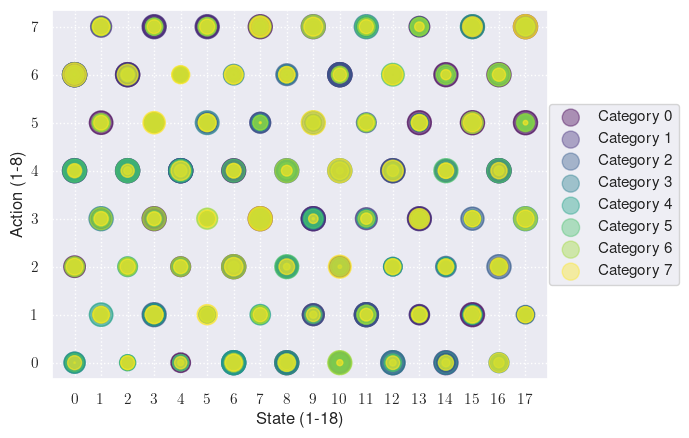

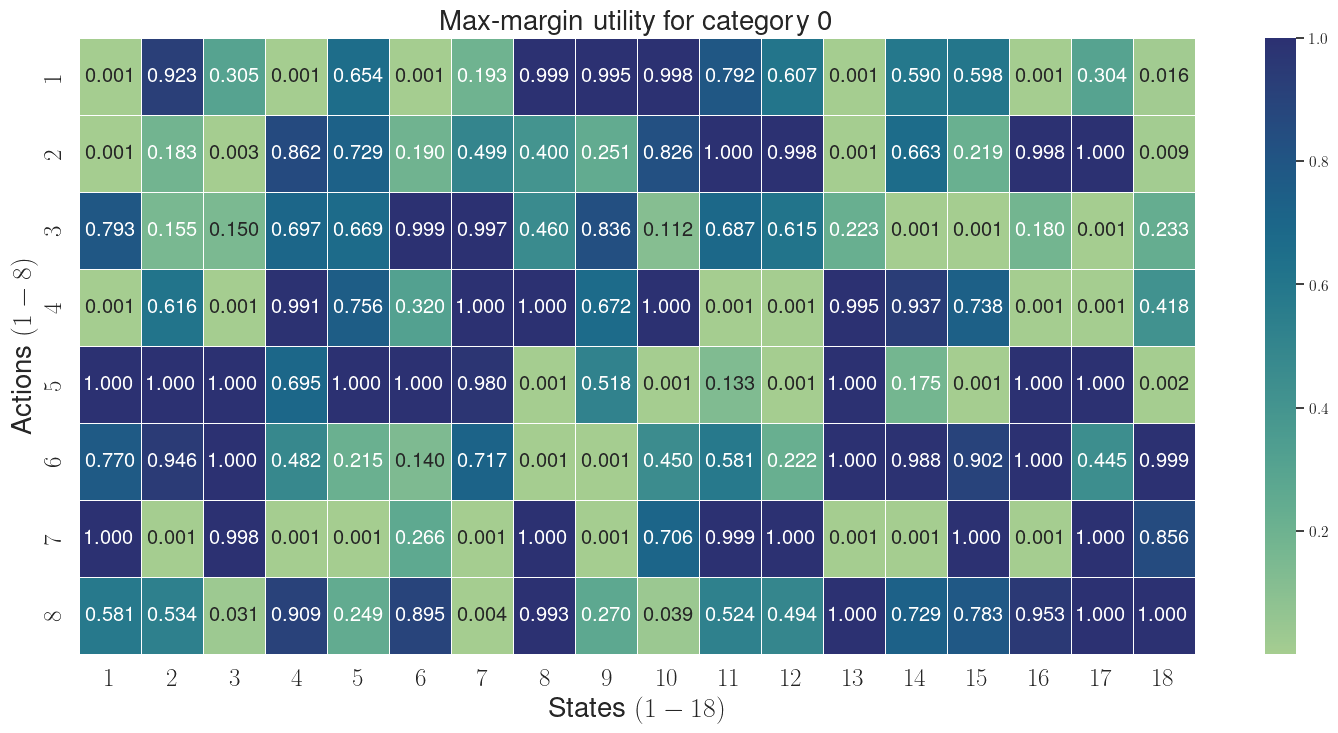

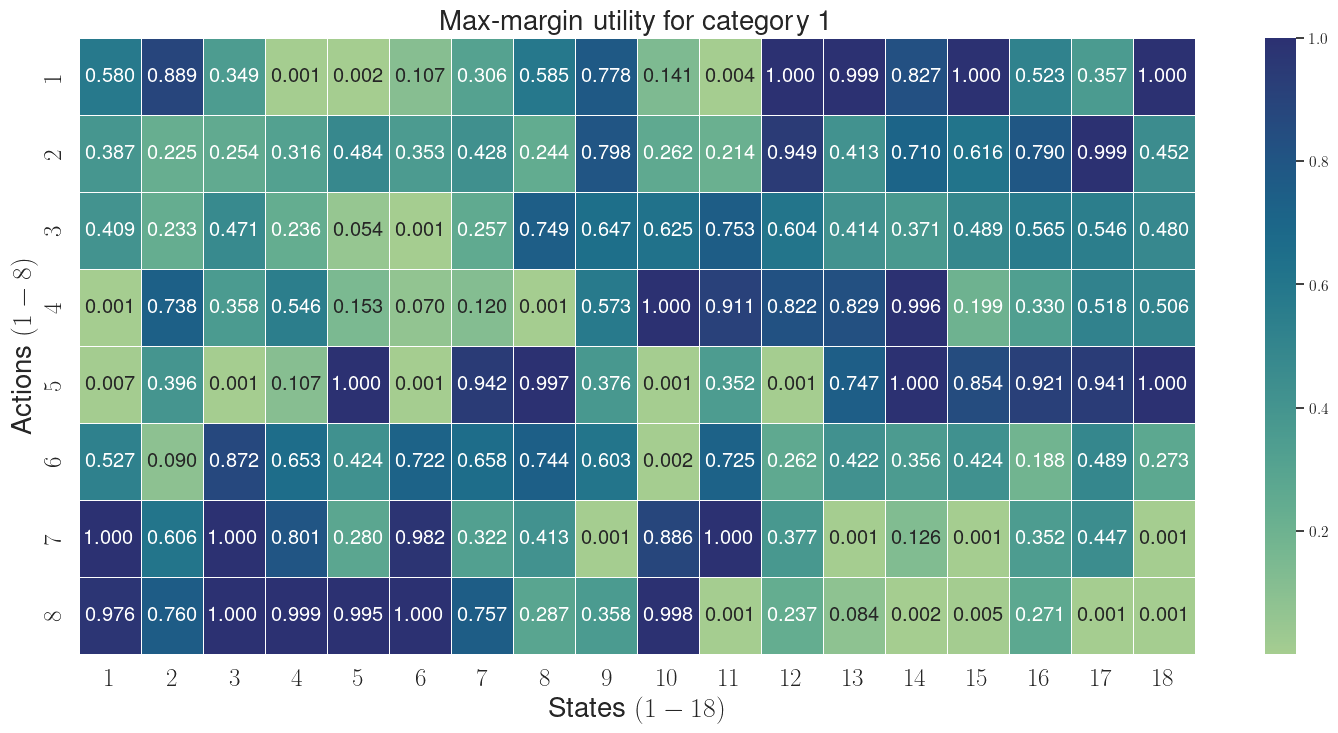

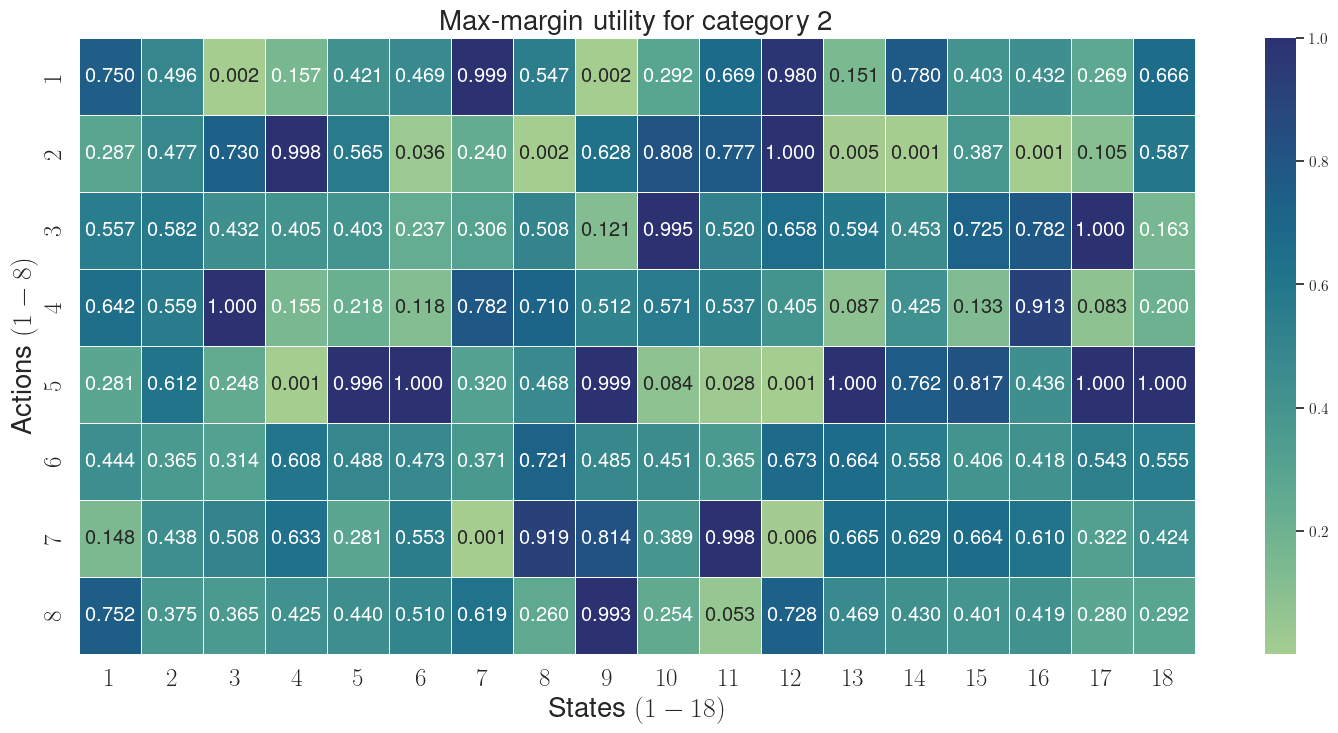

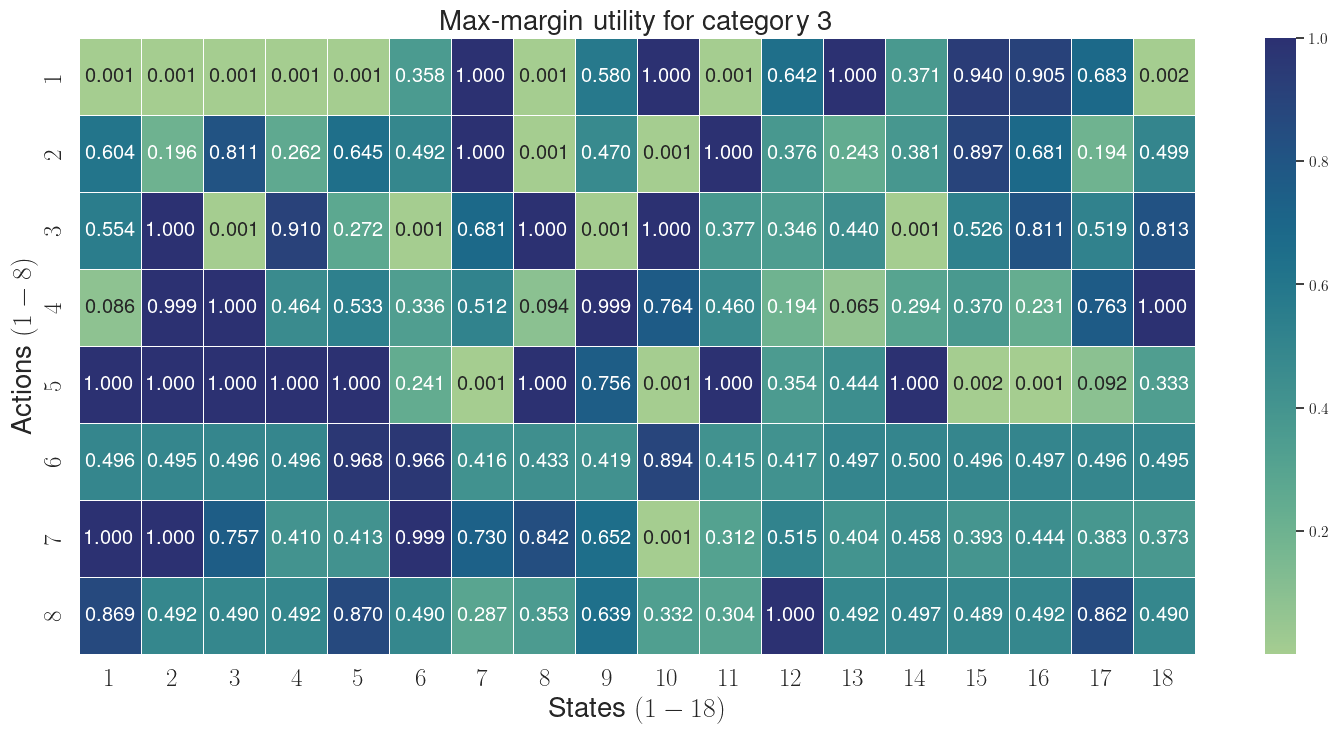

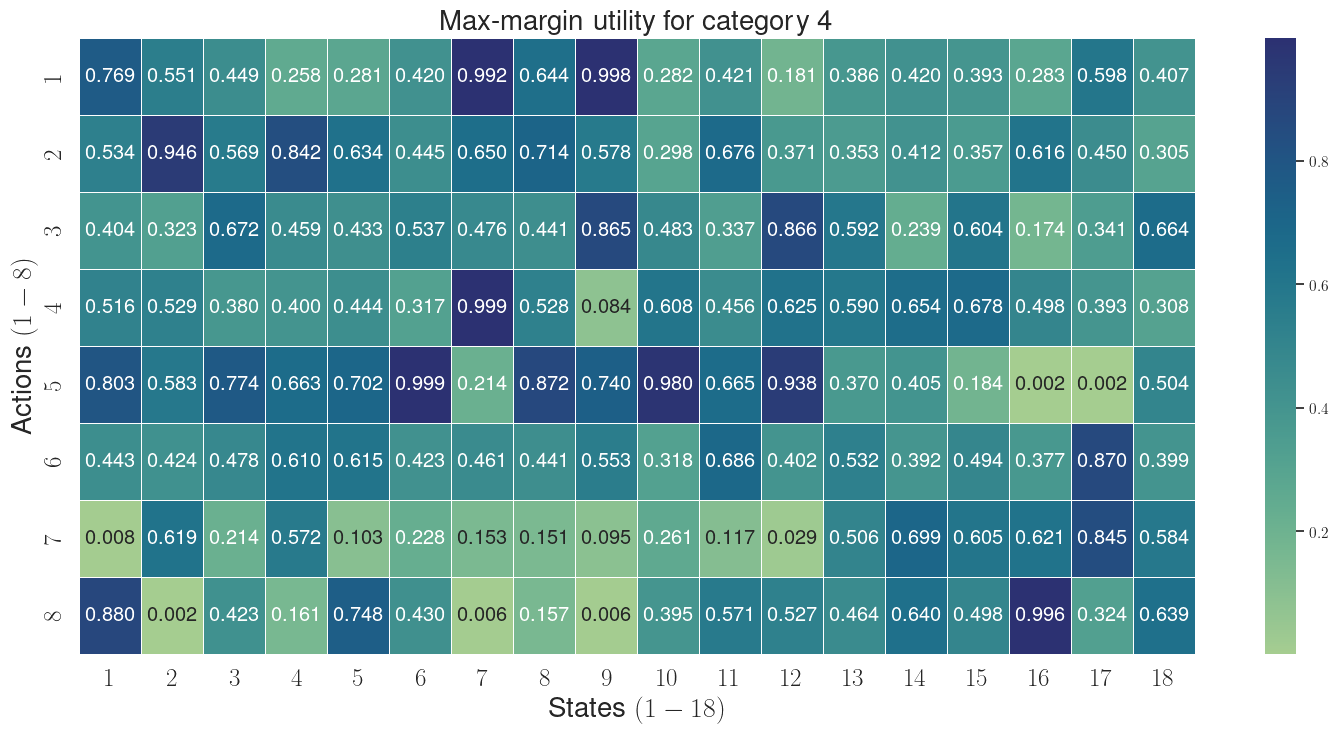

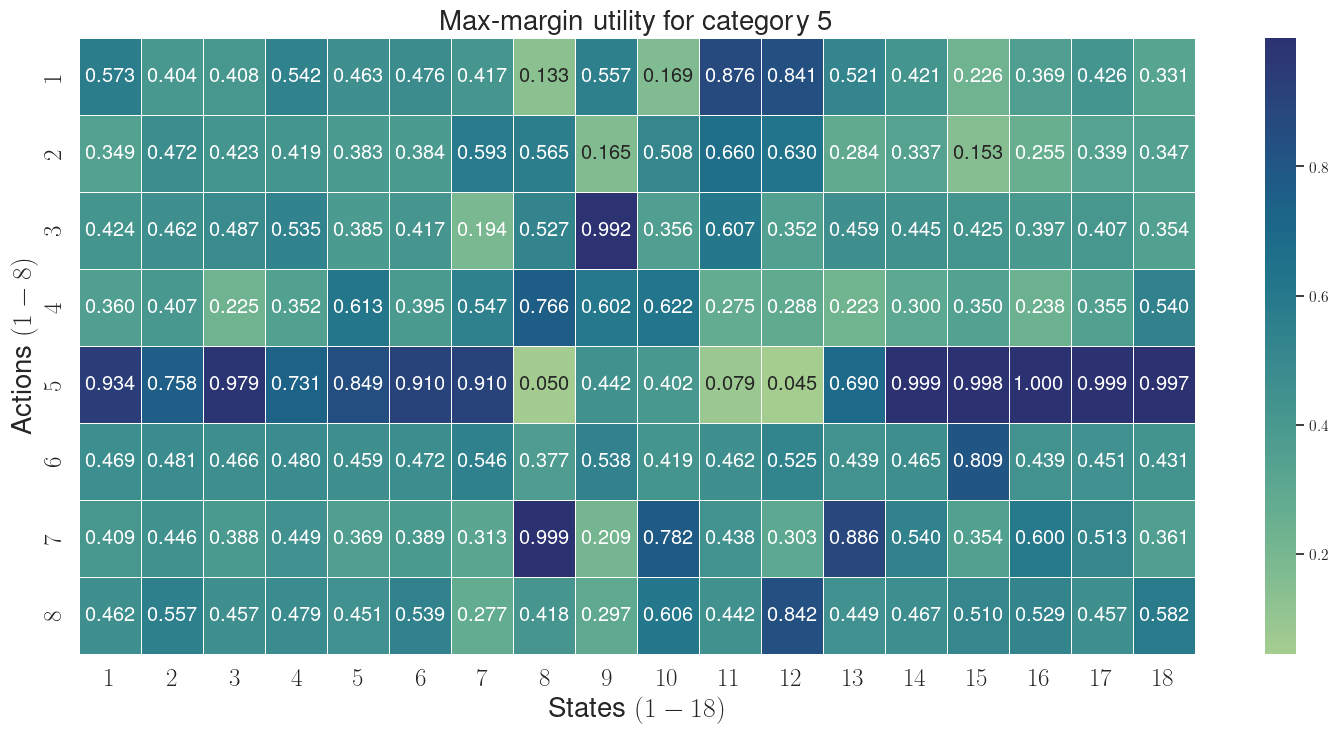

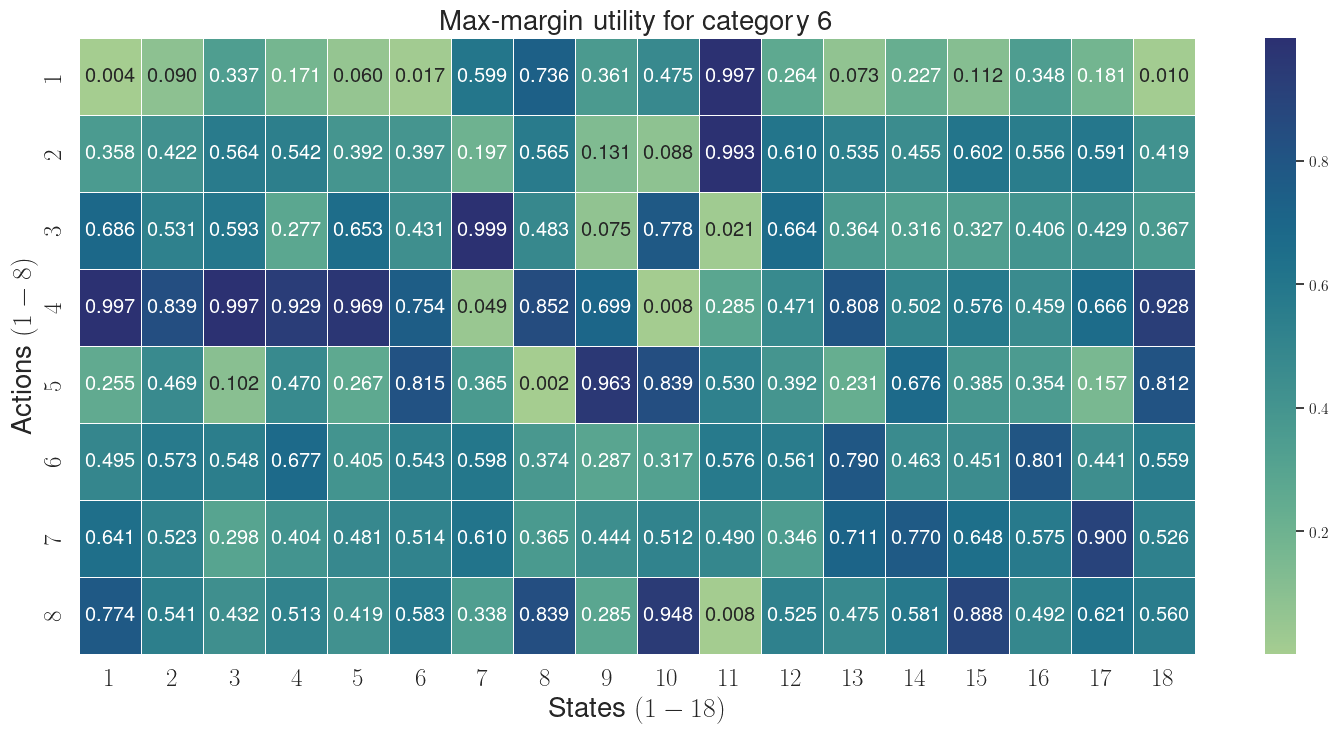

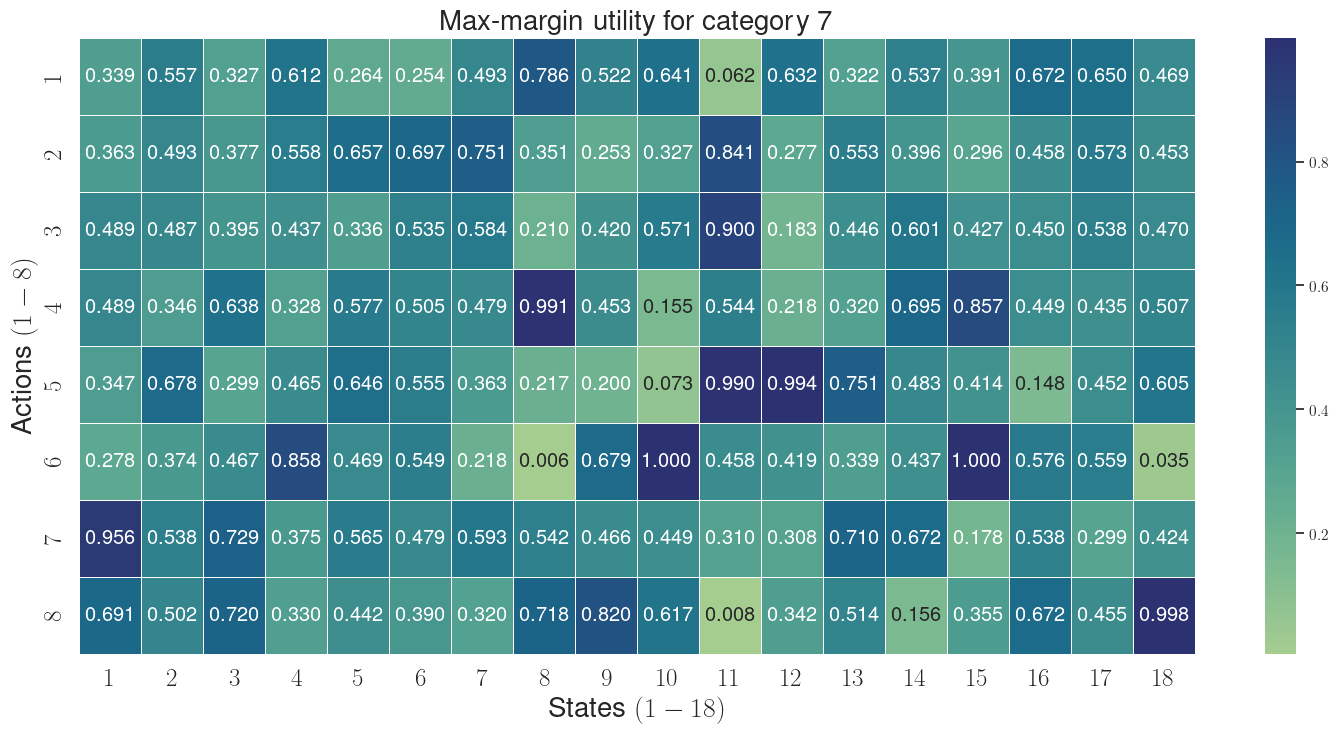

In [6]:
try:
  with open(baseurl + 'yt_metadata_final_maxmargin.pkl', 'rb') as f:
    maxmargin_data = pickle.load(f)
except:
  print("Sorry, the file you are looking for does not exist")

utils = maxmargin_data['utils']
import matplotlib.pyplot as plt
from matplotlib import cm

## create grid
belief_shape = posterior_probs_by_category[0].shape
num_states = belief_shape[1]
num_actions = belief_shape[0]
num_categs = len(list(posterior_probs_by_category.keys()))

state_grid = list(range(num_states))*num_actions
action_grid = list(range(num_actions))*num_states

maxmarginutils_viz = {}
maxmarginutils_viz['state_grid'] = state_grid
maxmarginutils_viz['action_grid'] = action_grid

cmap_for_plots = cm.get_cmap('viridis', num_categs)

plt.figure()
for categ in range(num_categs):
  maxmarginutils_viz[categ] = [maxmargin_data['utils'][categ][action_grid[i],state_grid[i]] for i in range(num_states*num_actions)]
  plt.scatter(state_grid,action_grid,
              c = [cmap_for_plots.colors[categ]]*(num_states*num_actions),
              s= 300*np.array(maxmarginutils_viz[categ]),
              alpha = 0.4)
plt.grid(linestyle='dotted')
plt.xlabel('State (1-18)')
plt.ylabel('Action (1-8)')
plt.xticks(list(range(num_states)))
plt.yticks(list(range(num_actions)))
plt.legend(['Category ' + str(key) for key in list(posterior_probs_by_category.keys())], loc = 'right', bbox_to_anchor=(1.28, 0.5) )

#####################

import seaborn as sns
for categ in range(num_categs):
  plt.figure(figsize = (num_states,num_actions))
  ax = sns.heatmap(maxmargin_data['utils'][categ],cmap = 'crest', annot = True, annot_kws = {'fontsize':14.5}, cbar_kws = {'shrink':1}, fmt = '.3f',  linewidth = .5)
  #ax.set(xlabel = 'States (1-18)', ylabel = 'Actions (1-8)', title = 'Sparsity-enhanced utility for category {}'.format(categ))
  ax.set_xlabel(r'States $(1-18)$', fontsize=20)
  ax.set_ylabel(r'Actions $(1-8)$', fontsize=20)
  ax.set_title(r'Max-margin utility for category {}'.format(categ), fontsize = 20)
  ax.set_xticklabels([r"$%d$" % (y+1) for y in range(num_states)], fontsize=18)
  ax.set_yticklabels([r"$%d$" % (y+1) for y in range(num_actions)], fontsize=18)
  
  plt.show()

## Contour Plots

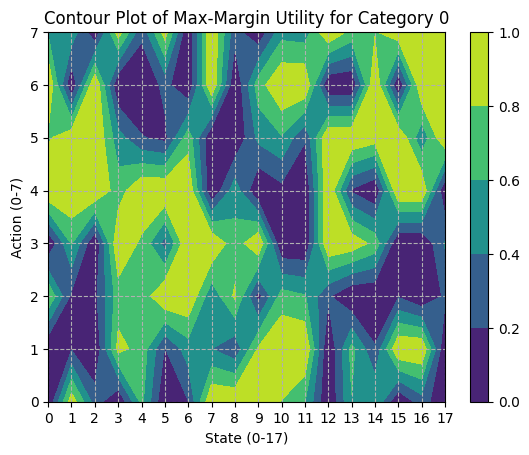

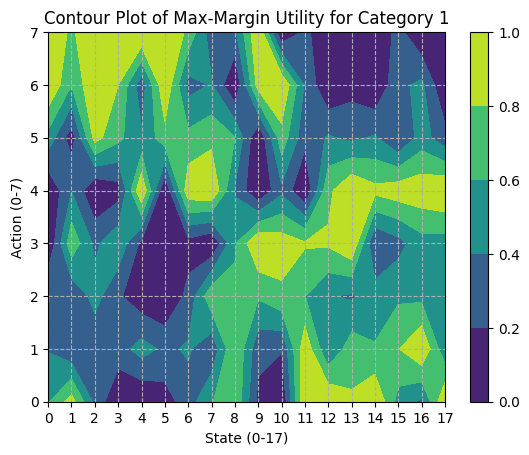

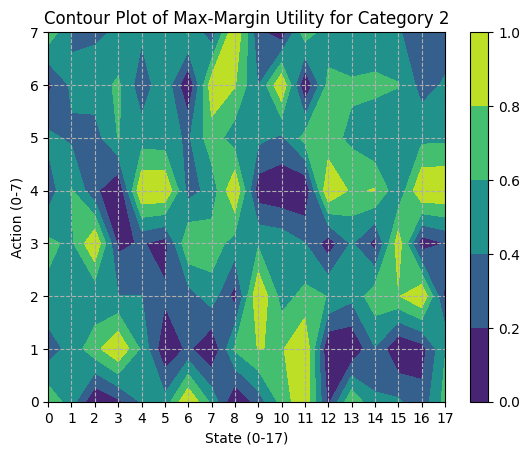

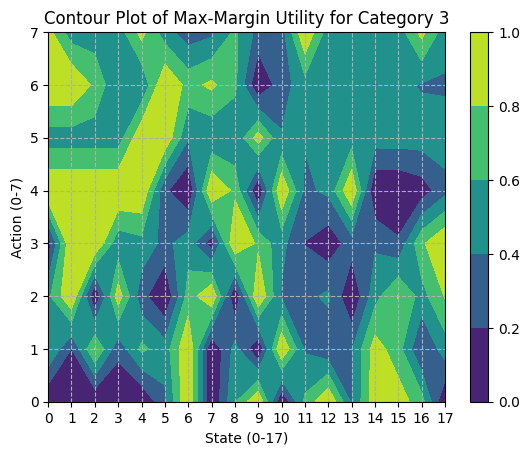

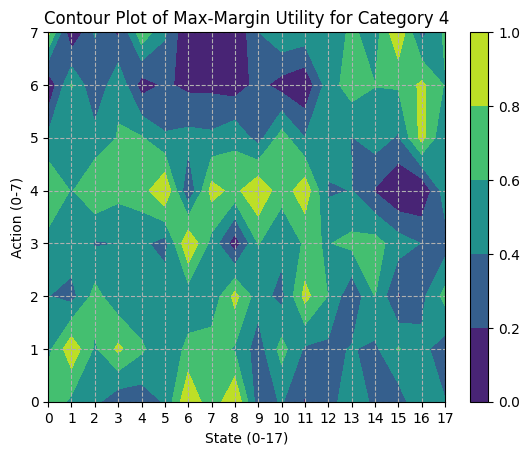

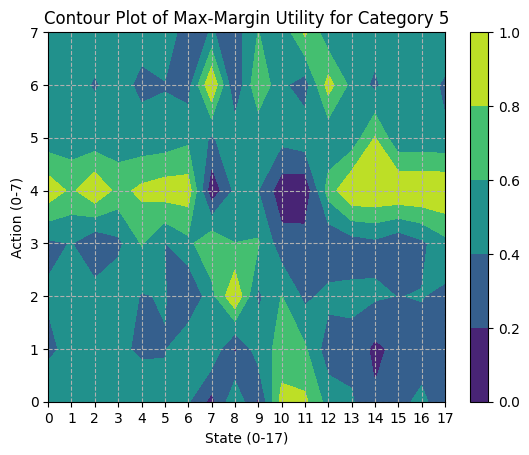

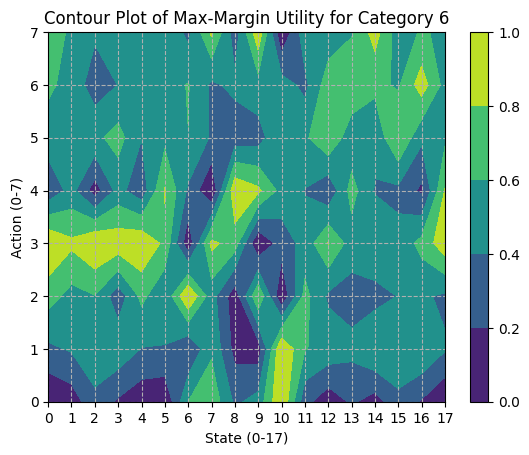

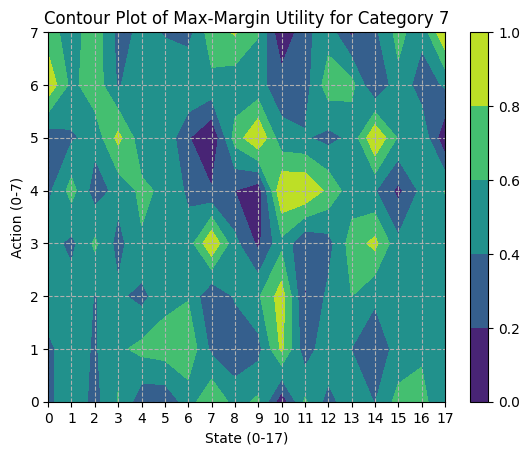

In [ ]:
[X, Y] = np.meshgrid(np.arange(num_states), np.arange(num_actions))

for categ in range(num_categs):
  Z = np.zeros(X.shape)
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      Z[i,j] = maxmargin_data['utils'][categ][i,j]
  fig, ax = plt.subplots()
  cs = ax.contourf(X,Y,Z,levels = 4, alpha = 1)
  plt.xlabel('State (1-18)')
  plt.ylabel('Action (1-8)')
  plt.grid(linestyle='dashed')
  plt.xticks(list(range(num_states)))
  plt.yticks(list(range(num_actions)))
  plt.title('Contour Plot of Max-Margin Utility for Category {}'.format(categ))

  cmap = fig.colorbar(cs)
  plt.show()
  


## Given action selection policy and priors, generate discrepancy matrix $[a_{j,k}], a_{j,k} = J(\alpha_j,U_k) - J(\alpha_k,U_k)$

In [ ]:
try:
  with open(baseurl + 'yt_metadata_final_maxmargin.pkl', 'rb') as f:
    maxmargin_data = pickle.load(f)
  with open(baseurl + 'yt_metadata_final_sparse.pkl', 'rb') as f:
    sparse_data = pickle.load(f)
except:
  print("Sorry, the file you are looking for does not exist")

# Load prior and act sel probs dictionaries
with open(baseurl + 'yt_metadata_category_action_selection_probs.pkl', 'rb') as f:
  actsels = pickle.load(f)


# get an np array of action selection probabilities (8 categories x 18 states x 8 actions) (not 3x2**3 since some actions never arise)
actsels_prob = np.array([actsels[i] for i in  range(len(priorkeys)) ])
print('Action selection array shape: ',actsels_prob.shape)


num_categs = len(list(posterior_probs_by_category.keys()))

utils_maxmargin = []
for categ in range(num_categs):
  utils_maxmargin = utils_maxmargin + list(maxmargin_data['utils'][categ].flatten())

utils_sparse = []
for categ in range(num_categs):
  utils_sparse = utils_sparse + list(sparse_data['utils'][categ].flatten())

################################################################################

def get_discrepancy_matrix(utils, actsels_prob = actsels_prob):
  '''
  Given action selection policy and priors, generate discrepancy matrix $[a_{j,k}], a_{j,k} = J(\alpha_j,U_k) - J(\alpha_k,U_k)$
  Input - actsels_prob - np array of size (num_categs,num_states,num_actions), and utils - 1-d array
  '''

  (num_categs,num_states,num_actions) = actsels_prob.shape 
  # Load prior and act sel probs dictionaries
  with open(baseurl + 'yt_metadata_category_priors.pkl', 'rb') as f:
    priors = pickle.load(f)
    
  # actsels_prob is given

  # get an np array of priors (7 x 18) array (7 categories, 18 states)
  priorkeys = [elem for elem in list(priors.keys()) if type(elem)==int]
  assert len(priorkeys) == num_categs, "Number of categories mismatch"

  priors_prob = np.array([priors[i] for i in  range(len(priorkeys)) ])
  print('Prior array shape: ',priors_prob.shape)

  # # get an np array of action selection probabilities (8 categories x 18 states x 8 actions) (not 3x2**3 since some actions never arise)
  # assert actsels_prob.shape == (num_categs,num_states,num_actions), "Action selection probability matrix not in right dimensions"
  print('Action selection array shape: ',actsels_prob.shape)

  posterior_probs_by_category = {}
  act_probs_by_category = {}

  for categ in priorkeys: # parametrizes the prior
    act_probs_by_category[categ] = []
    posterior_probs_by_category[categ] = []
    for action in range(num_actions):
      # compute p(a) = prior*p(a|x)
      act_probs_by_category[categ].append(priors_prob[categ,:]@actsels_prob[categ,:,action])
      # compute p(x|a) = p(a|x)*prior/p(a)
      posterior_probs_by_category[categ].append(actsels_prob[categ,:,action]*priors_prob[categ,:]/(actsels_prob[categ,:,action]@priors_prob[categ,:]))

    act_probs_by_category[categ] = np.array(act_probs_by_category[categ])
    posterior_probs_by_category[categ] = np.array(posterior_probs_by_category[categ])
  ##############################################################################

  belief_shape = posterior_probs_by_category[0].shape
  assert utils.shape[0] == num_categs*num_states*num_actions

  exputil_list = []
  ineq_mat = np.zeros((num_categs,num_categs))
  for categ1 in range(num_categs): # NIAC is for a pair of categories - categ1 has higher expected utility
    for categ2 in range(num_categs):
      if categ1 != categ2:
        offset = categ1*num_states*num_actions
        exputil1 = sum([ act_probs_by_category[categ1][a]*(posterior_probs_by_category[categ1][a,:]@utils[ offset + a*num_states: offset + (a+1)*num_states]) for a in range(num_actions) ])
        # \sum_{x,a} p_k(x|a)p_k(a)u_k(x,a)

        cross_pos_beliefs = np.zeros(posterior_probs_by_category[0].shape)
        cross_act_probs = np.zeros((num_actions,))
        act_sel_2 = np.array(actsels_prob[categ2,:,:])

        for a in range(num_actions):
          cross_pos_beliefs[a,:] = priors[categ1]*np.array(act_sel_2[:,a]).reshape((num_states,))  #### (prior(x)p_{k'}(a|x))
          cross_act_probs[a] = sum(cross_pos_beliefs[a,:]) #### sum_{x} (prior(x')p_{k'}(a|x'))
          cross_pos_beliefs[a,:] = cross_pos_beliefs[a,:]/cross_act_probs[a] #### (prior(x)p_{k'}(a|x))/sum_{x} (prior(x')p_{k'}(a|x'))
 
        offset = categ1*num_actions*num_states
        exputil2 = sum([ cross_act_probs[a]*max( [cross_pos_beliefs[a,:]@utils[offset + a1*num_states: offset + (a1+1)*num_states] for a1 in range(num_actions)]  ) for a in range(num_actions)])
        # \sum_{a} p_{k'}(a) (\max_{b} \sum_{x} p_{k'}(x|a) u_{k}(x,a)) - cross max utility gained by using action selection from k' in category k

        ## Debuggin blurb: print(categ1,categ2,'utils',exputil1,exputil2)
        ineq_mat[categ1,categ2] = (exputil2 - exputil1)
    exputil_list.append(exputil1)
  return ineq_mat,exputil_list


discrepancy, exputil = get_discrepancy_matrix(utils = np.array(utils_maxmargin))
disc_matrix_maxmargin = {'data':discrepancy,
                         'expected-utilities': exputil,
                         'description': '(i,j)th element is J(alpha_j,U_i) - J(alpha_i,U_i)'
}

discrepancy, exputil = get_discrepancy_matrix(utils = np.array(utils_sparse))
disc_matrix_sparse = {'data': discrepancy,
                      'expected-utilities':exputil,
                      'description': '(i,j)th element is J(alpha_j,U_i) - J(alpha_i,U_i)'
}

with open(baseurl + 'yt_metadata_discrepancy_matrix_maxmargin.pkl', 'wb') as f:
  pickle.dump(disc_matrix_maxmargin,f)

with open(baseurl + 'yt_metadata_discrepancy_matrix_sparse.pkl', 'wb') as f:
  pickle.dump(disc_matrix_sparse,f) 

disc_matrix_maxmargin

Action selection array shape:  (8, 18, 8)
Prior array shape:  (8, 18)
Action selection array shape:  (8, 18, 8)
Prior array shape:  (8, 18)
Action selection array shape:  (8, 18, 8)


{'data': array([[ 0.        ,  0.00288728,  0.01009112,  0.00040277,  0.06314731,
          0.08107056,  0.07459994,  0.00405985],
        [-0.03691986,  0.        , -0.01976897, -0.03456344, -0.00896162,
         -0.00912682,  0.00329803, -0.01680321],
        [-0.04391492, -0.03933615,  0.        , -0.04224477,  0.00596184,
          0.00708954,  0.00739628, -0.03254825],
        [-0.03274276, -0.02721407, -0.01696451,  0.        , -0.00317992,
         -0.01359322, -0.01155838, -0.00804425],
        [-0.05876186, -0.05467562, -0.05202312, -0.04730528,  0.        ,
         -0.03071793, -0.03127123, -0.04833157],
        [-0.0727506 , -0.07278047, -0.06059514, -0.07557238, -0.03138134,
          0.        , -0.03204572, -0.06674375],
        [-0.05238902, -0.04926747, -0.04141329, -0.04743293, -0.03230794,
         -0.03110685,  0.        , -0.03801365],
        [-0.03997053, -0.03896377, -0.03620323, -0.03580645, -0.0276093 ,
         -0.03024963, -0.02999887,  0.        ]]),
 'expe

## Check discrepancy matrix generation